# Capstone Project - The Battle of the Neighborhoods
## Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find what makes a resturant succesful in a major Italian touristic city. Specifically, this report will be targeted to stakeholders interested in opening a *restaurant* in **Florence**, Italy.

We are particularly interested in understanding which factors might correlate with success of a food venue in this town and, as such, we can try to predict some measure of success of already existing venues via a set of features and machine learning techniques. By looking at the performance obtained and the relative importance of each feature in the model, we can then see what factor might determine the success of a restaurant. In addition, a prediction of how a restaurant will perform based on those same features can be obtained as well.

The outcome of this analysis might then inform the decision of stakeholders willing to open a restaurant in Florence, while providing a foundation for future research in similar town and/or with additional/different features. 

## Data <a name='data'/>

Based on definition of our problem, we will need to find the following:
* information about existent restaurants in Florence, including their characteristics and a measure of their performance.

As a ready database containing such information could not be found, we will proceed in creating one from scratch using different data sources. In this process, candidate features and target variables will be individuated.

Following data sources will be needed to extract/generate the required information:
* Name of neighborhoods of Florence and some general demographic information of their macro-areas will be scraped from the table contained in the following Wikipedia page: [https://it.wikipedia.org/wiki/Quartieri_di_Firenze](https://it.wikipedia.org/wiki/Quartieri_di_Firenze).
* coordinates of the neighborhoods will be obtained via [geopy](https://geopy.readthedocs.io/en/stable/), a python open-source library allowing to send requests to **Nominatim's API**. 
* restaurants information, including their type and location in every neighborhood will be obtained using **Foursquare API**
* ratings of restaurants in Florence will be scraped from the travel website TripAdvisor, at the following address [https://www.tripadvisor.co.uk//Restaurants-g187895-oa30-Florence_Tuscany.html#EATERY_LIST_CONTENTS](https://www.tripadvisor.co.uk//Restaurants-g187895-oa30-Florence_Tuscany.html#EATERY_LIST_CONTENTS)

Once obtained, the different data can be variously combined in a form that is both theoretically sound and effective to reach our main goal of assessing the importance of different features in a restaurant success, as well as predicting the success of a new venue based on such features.

In [25]:
# Import required libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files


try:
    from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
except ModuleNotFoundError:
    # If geopy library was not found: install it
    print("Library geopy not found: installing it before continuing")
    !pip install geopy
    from geopy.geocoders import Nominatim
    
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

try:
    import folium # map rendering library
except ModuleNotFoundError:
    # If folium library was not found: install it
    print("Library folium not found: installing it before continuing")
    !pip install folium
    import folium

import urllib.request
import time
from bs4 import BeautifulSoup
import re    

print('Libraries imported.')

Libraries imported.


### Obtaining the data concerning the neighborhoods of Florence
As mentioned, the name and some characteristics of the neighborhoods of Florence will be obtained by scraping an existent table on Wikipedia ([https://it.wikipedia.org/wiki/Quartieri_di_Firenze](https://it.wikipedia.org/wiki/Quartieri_di_Firenze)). Such a table contains the name of the neighborhoods grouped inside the *quartieri* or boroughs of Florence, representing an higher level division of the city. Demographic information at the level per boroughs (*n.b.* not per neighborough) are included as well in the table. Such information seem already valuable predictors for the future prediction task, so we will keep them in mind but remembering that they pertain boroughs and, as such, are shared by neighborhoods in the same borough. From the scraped Wikipedia page, a series of transformations will allow to obtain a dataframe having each neighborhood as a row so that we can get the exact coordinates for each neighborhood and store them as well. Visualising the city with its borough, first, and with its neighborhoods, then, will give us a visual understanding of which geographic area we are analysing.
***
#### Scraping the Wikipedia page
Scraping the wikipedia page can be easily done with the *read_html* method of Pandas. The method search for $<table>$ tags in the given html page and returns a list of all the found tables converted in Pandas' dataframes on the basis of the internal structure of the tables in the web page (as defined by the $<tr>$ and $<td>$ tags).  

In [11]:
# The .read_html method from pandas library automatically 

url = 'https://it.wikipedia.org/wiki/Quartieri_di_Firenze'
Florence_Boroughs = pd.read_html(url)[0]
Florence_Boroughs

,Quartiere,Superficie(km²),Abitanti(5/06),Densità(ab/km²),Presidente,Suddivisioni
0,Quartiere 1 Centro Storico,11396,67.170,5.894,Maurizio Sguanci (PD),Centro Storico · Il Prato · Fortezza da Basso ...
1,Quartiere 2 Campo di Marte,23406,88.588,3.784,Michele Pierguidi (PD),Campo di Marte · Le Cure · Viali · Bellariva ·...
2,Quartiere 3 Gavinana-Galluzzo,22312,40.907,1.833,Serena Perini (PD),Gavinana · Galluzzo · San Gaggio · Collina sud...
3,Quartiere 4 Isolotto-Legnaia,16991,66.636,3.921,Mirko Dormentoni (PD),Isolotto · Legnaia · Argingrosso · Cintoia · I...
4,Quartiere 5 Rifredi,28171,103.761,3.683,Cristiano Balli (PD),Statuto · Romito · Viali · Fortezza da Basso ·...
5,Firenze,102276,367.062,3.589,NaN,NaN


As it can be seen, the last row contains just the overall information about Florence, so it can be discarded.

In [14]:
Florence_Boroughs = Florence_Boroughs.loc[:4]
Florence_Boroughs

,Quartiere,Superficie(km²),Abitanti(5/06),Densità(ab/km²),Presidente,Suddivisioni
0,Quartiere 1 Centro Storico,11396,67.170,5.894,Maurizio Sguanci (PD),Centro Storico · Il Prato · Fortezza da Basso ...
1,Quartiere 2 Campo di Marte,23406,88.588,3.784,Michele Pierguidi (PD),Campo di Marte · Le Cure · Viali · Bellariva ·...
2,Quartiere 3 Gavinana-Galluzzo,22312,40.907,1.833,Serena Perini (PD),Gavinana · Galluzzo · San Gaggio · Collina sud...
3,Quartiere 4 Isolotto-Legnaia,16991,66.636,3.921,Mirko Dormentoni (PD),Isolotto · Legnaia · Argingrosso · Cintoia · I...
4,Quartiere 5 Rifredi,28171,103.761,3.683,Cristiano Balli (PD),Statuto · Romito · Viali · Fortezza da Basso ·...


The fields of the above dataframe are:
* Quartiere: the Borough name
* Superficie: the total area of the borough, measured in squared kilometers
* Abitanti: number of people living in the borough
* Densita: number of people per squared kilometer
* Presidente: name of the president of the borough (not useful for our analysis)
* Suddivisioni: neighborhoods inside the borough

#### Obtaining coordinates for city's boroughs and visualising them
We can get an initial visual idea of the city by getting the coordinates of the 5 boroughs and plotting them with the library *folium*.

In [25]:
# Creating empty lists to store the geocoordinates of the boroughs

lats = []
longs = []
for borough in Florence_Boroughs['Quartiere']:
    # passing the name of the Borough followed by Florence, Italy as the location to be found.
    address = borough[:11]+', Florence, Italy' 

    geolocator = Nominatim(user_agent="fl_explorer") # instatiating the Nominatim API connection
    location = geolocator.geocode(address) # by using the method geocode of our instance, we obtain the geocoordinates
    lats.append(location.latitude) # storing latitude of current borough
    longs.append(location.longitude) # storing longitude of current borough
    print('The geograpical coordinate of {}, Florence, are {}, {}.'.format(borough, location.latitude, location.longitude))

# We create two new columns in the existing dataframe, storing the results from above
Florence_Boroughs['Latitude'] = lats
Florence_Boroughs['Longitude'] = longs
Florence_Boroughs # Check the result

The geograpical coordinate of Quartiere 1 Centro Storico, Florence, are 43.7692631, 11.254821533849798.
The geograpical coordinate of Quartiere 2 Campo di Marte, Florence, are 43.7990279, 11.275214866358684.
The geograpical coordinate of Quartiere 3 Gavinana-Galluzzo, Florence, are 43.7458989, 11.25731421720064.
The geograpical coordinate of Quartiere 4 Isolotto-Legnaia, Florence, are 43.769726500000004, 11.202677212134315.
The geograpical coordinate of Quartiere 5 Rifredi, Florence, are 43.80852385, 11.233577381967027.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,Quartiere,Superficie(km²),Abitanti(5/06),Densità(ab/km²),Presidente,Suddivisioni,Latitude,Longitude
0,Quartiere 1 Centro Storico,11396,67.170,5.894,Maurizio Sguanci (PD),Centro Storico · Il Prato · Fortezza da Basso ...,43.769263,11.254822
1,Quartiere 2 Campo di Marte,23406,88.588,3.784,Michele Pierguidi (PD),Campo di Marte · Le Cure · Viali · Bellariva ·...,43.799028,11.275215
2,Quartiere 3 Gavinana-Galluzzo,22312,40.907,1.833,Serena Perini (PD),Gavinana · Galluzzo · San Gaggio · Collina sud...,43.745899,11.257314
3,Quartiere 4 Isolotto-Legnaia,16991,66.636,3.921,Mirko Dormentoni (PD),Isolotto · Legnaia · Argingrosso · Cintoia · I...,43.769727,11.202677
4,Quartiere 5 Rifredi,28171,103.761,3.683,Cristiano Balli (PD),Statuto · Romito · Viali · Fortezza da Basso ·...,43.808524,11.233577


Now let's get the general coordinates of Florence so that we know where to zoom in the map.

In [653]:
address = 'Florence, Italy'

geolocator = Nominatim(user_agent="fl_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Florence are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Florence are 43.7698712, 11.2555757.


Let's print this first map of Florence and its five boroughs

In [655]:
florence_map = folium.Map(location=[latitude, longitude], zoom_start=11)
for row in Florence_Boroughs.iterrows():
    label = '{}'.format(row[1]['Quartiere'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row[1]['Latitude'],row[1]['Longitude']],
        radius=5,
        popup = label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=.75,
        parse_html=False
    ).add_to(florence_map)
    
florence_map

#### Extracting the individual neighborhoods from the boroughs' dataframe, creating and visualising a new dataframe having neighborhoods and their location on each row
To extract each neighborhood, we can first notice that the neighborhoods are separated in a specific way inside the *Suddivisioni* field. We can then transform each cell of that field in a list with the .split method applied on each of the cells, whereas we are splitting the long string containing each neighborhood in a borough on the basis of the separator between neighborhoods.

In [212]:
Florence_Boroughs['Suddivisioni'] = Florence_Boroughs['Suddivisioni'].transform(lambda x: x.split(' · '))
Florence_Boroughs

,Quartiere,Superficie(km²),Abitanti(5/06),Densità(ab/km²),Presidente,Suddivisioni,Latitude,Longitude
0,Quartiere 1 Centro Storico,11396,67.170,5.894,Maurizio Sguanci (PD),"[Centro Storico, Il Prato, Fortezza da Basso, ...",43.769263,11.254822
1,Quartiere 2 Campo di Marte,23406,88.588,3.784,Michele Pierguidi (PD),"[Campo di Marte, Le Cure, Viali, Bellariva, Co...",43.799028,11.275215
2,Quartiere 3 Gavinana-Galluzzo,22312,40.907,1.833,Serena Perini (PD),"[Gavinana, Galluzzo, San Gaggio, Collina sud, ...",43.745899,11.257314
3,Quartiere 4 Isolotto-Legnaia,16991,66.636,3.921,Mirko Dormentoni (PD),"[Isolotto, Legnaia, Argingrosso, Cintoia, I Ba...",43.769727,11.202677
4,Quartiere 5 Rifredi,28171,103.761,3.683,Cristiano Balli (PD),"[Statuto, Romito, Viali, Fortezza da Basso, Ri...",43.808524,11.233577


Now that the Florence_Boroughs dataframe contains each neighborhood per borough in the form of a list, we can create a new dictionary and populate it with the neighborhoods obtained by first looping through the boroughs and inside each of these loops by looping through the list of neighborhoods. Each neighborhood, then, will be a separate value in the Neighborhood entry of the dictionary, while the corresponding borough and demographic features will be duplicated for each neighborhood sharing them.

In [215]:
# Create an empty dictionary with keys corresponding to what will be the columns in the new dataframe
florence_neighborhoods = {'Borough':[],'Inhabitans':[], 'Density':[], 'Area':[],'Neighborhood':[]}

# Iterate through the Florence_Boroughs dataframe to split the neighbourhoods and populate the dictionary
for row in Florence_Boroughs.iterrows():
    for neighbourhood in row[1]['Suddivisioni']:
        florence_neighborhoods['Borough'].append(row[1]['Quartiere'])
        florence_neighborhoods['Inhabitans'].append(row[1]['Abitanti(5/06)'])
        florence_neighborhoods['Density'].append(row[1]['Densità(ab/km²)'])
        florence_neighborhoods['Area'].append(row[1]['Superficie(km²)'])
        florence_neighborhoods['Neighborhood'].append(neighbourhood)

# Convert the dictionary to a pandas dataframe
florence_neigh =  pd.DataFrame(florence_neighborhoods)

# Check the difference in length between the Florence_Boroughs dataframe and the newly created one
print("Borough dataframe length = {}. Neighbourhood dataframe length = {}".format(len(Florence_Boroughs),
                                                                                  len(florence_neigh)))

florence_neigh.head() # check the new dataframe

Borough dataframe length = 5. Neighbourhood dataframe length = 52


,Borough,Inhabitans,Density,Area,Neighborhood
0,Quartiere 1 Centro Storico,67.17,5.894,11396,Centro Storico
1,Quartiere 1 Centro Storico,67.17,5.894,11396,Il Prato
2,Quartiere 1 Centro Storico,67.17,5.894,11396,Fortezza da Basso
3,Quartiere 1 Centro Storico,67.17,5.894,11396,Viali
4,Quartiere 1 Centro Storico,67.17,5.894,11396,San Jacopino


In [216]:
florence_neigh.tail() # checking the last entries of the new dataframe (notice how Borough and demographic info are duplicated)

,Borough,Inhabitans,Density,Area,Neighborhood
47,Quartiere 5 Rifredi,103.761,3.683,28171,Brozzi
48,Quartiere 5 Rifredi,103.761,3.683,28171,Le Piagge
49,Quartiere 5 Rifredi,103.761,3.683,28171,Peretola
50,Quartiere 5 Rifredi,103.761,3.683,28171,Quaracchi
51,Quartiere 5 Rifredi,103.761,3.683,28171,Ponte di mezzo


Now we can replicate what we did above to find the coordinates of the boroughs, but this time looping through the nighborhoods dataframe.

In [225]:
lats = []
longs = []
for neighborough in florence_neigh['Neighborhood']:
    address = neighborough + ', Florence, Italy'

    geolocator = Nominatim(user_agent="fl_explorer")
    location = geolocator.geocode(address)
    if location is None:
        latitude = np.nan
        longitude = np.nan
    else:
        latitude = location.latitude
        longitude = location.longitude
    lats.append(latitude)
    longs.append(longitude)
    print('The geograpical coordinate of {}, Florence, are {}, {}.'.format(neighborough, latitude, longitude))

florence_neigh['Latitude'] = lats
florence_neigh['Longitude'] = longs


The geograpical coordinate of Centro Storico, Florence, are 43.7692631, 11.254821533849798.
The geograpical coordinate of Il Prato, Florence, are 44.0450724, 11.5496831.
The geograpical coordinate of Fortezza da Basso, Florence, are 43.78163015, 11.248853076512788.
The geograpical coordinate of Viali, Florence, are 43.7597319, 11.2697679.
The geograpical coordinate of San Jacopino, Florence, are 43.7838253, 11.2398143.
The geograpical coordinate of Collina sud, Florence, are nan, nan.
The geograpical coordinate of San Gaggio, Florence, are 43.7519007, 11.2381206.
The geograpical coordinate of Campo di Marte, Florence, are 43.7817975, 11.2864567.
The geograpical coordinate of Le Cure, Florence, are 43.7870158, 11.2693344.
The geograpical coordinate of Viali, Florence, are 43.7597319, 11.2697679.
The geograpical coordinate of Bellariva, Florence, are 43.7680502, 11.2843365.
The geograpical coordinate of Coverciano, Florence, are 43.7787422, 11.2959996.
The geograpical coordinate of Setti

NameError: name 'head' is not defined

In [226]:
florence_neigh.head() # Check that the coordinates have been correctly inserted

,Borough,Inhabitans,Density,Area,Neighborhood,Latitude,Longitude
0,Quartiere 1 Centro Storico,67.17,5.894,11396,Centro Storico,43.769263,11.254822
1,Quartiere 1 Centro Storico,67.17,5.894,11396,Il Prato,44.045072,11.549683
2,Quartiere 1 Centro Storico,67.17,5.894,11396,Fortezza da Basso,43.781630,11.248853
3,Quartiere 1 Centro Storico,67.17,5.894,11396,Viali,43.759732,11.269768
4,Quartiere 1 Centro Storico,67.17,5.894,11396,San Jacopino,43.783825,11.239814


In [227]:
# Some coordinates could not be found by the API. We then drop the rows containg NaN, corresponding to those coordinates

before_drop = len(florence_neigh)
florence_neigh.dropna(axis = 0, inplace=True)
florence_neigh.reset_index(drop=True, inplace=True)
after_drop = len(florence_neigh)
print("Before dropping NaN values dataframe had {} rows. Now it has {} rows.".format(before_drop, after_drop))

Before dropping NaN values dataframe had 52 rows. Now it has 48 rows.


By saving this dataframe in a csv format, we can both create a checkpoint so that if we want to start this notebook from this point we can just load the .csv dataframe and, at the same time, we have a new dataframe that might prove useful in future occasions.

In [233]:
florence_neigh.to_csv('FlorenceNeighborhoods.csv')

Finally, let's visualise the neighborhoods of Florence in the same way as we did for the Boroughs. This time, however, we superimpose the neighborhoods on the already existing map containing the boroughs.

In [656]:
for row in florence_neigh.iterrows():
    label = '{}, {}'.format(row[1]['Neighborhood'], row[1]['Borough'])
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [row[1]['Latitude'],row[1]['Longitude']],
        radius=5,
        popup = label,
        color='green',
        fill=True,
        fill_color='#4186cc',
        fill_opacity=.25,
        parse_html=False
    ).add_to(florence_map)

In [657]:
# The resulting map shows the boroughs in the red circles and the neighborhoods in the green ones 

florence_map

### Obtaining Restaurants and their locations via Foursquare API
At this point, we have the coordinates for each neighborhood. By passing such coordinates into the foursquare API, then, we can obtain a list of venues that are contained in Foursquare's database. These venues can then be filterd by category so that we save just the restaurants, finally creating a dataframe of Florentine restaurants with associated geolocation data and restaurant category.
***
#### Connect to foursquare api
First, we connect to foursquare with the personal credentials

In [19]:
CLIENT_ID = 'ZIOD2EFJF5VTEDE3GK1VYGJ0P0WRJE3UVZ1RXOBFMFGB5VT0' # my Foursquare ID
CLIENT_SECRET = 'N3RQ2KSOLN3XOCYHZVB122DSPS4BR3RO4CI24VJ2ZBMSIUVT' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#### Define the function to connect to foursquare api and get nearby values for each neighbourhood
The below function allow to send two different types of request to foursquare API: explore and trending. In our case, we will use the explore endpoint that returns a number of venues (whereas the maximum number returned is defined by the *LIMIT* parameter) inside a specified radius of the given location (in our case the coordinates of the individual neighborhoods).

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100, trending = False):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        endpoint = 'trending' if trending else 'explore'
        
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            endpoint,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
# Apply the function to our neighborhood dataframe

florence_venues = getNearbyVenues(names=florence_neigh['Neighborhood'],
                                   latitudes=florence_neigh['Latitude'],
                                   longitudes=florence_neigh['Longitude']
                                  )

florence_venues.head() # check results

Centro Storico
Il Prato
Fortezza da Basso
Viali
San Jacopino
San Gaggio
Campo di Marte
Le Cure
Viali
Bellariva
Coverciano
Settignano
Gavinana
Galluzzo
San Gaggio
Sorgane
Bandino
Paradiso
San Marcellino
Isolotto
Legnaia
Argingrosso
Cintoia
I Bassi
La Casella
Le Torri
Mantignano
Monticelli
Pignone
San Lorenzo a Greve
Soffiano
San Quirico
Torcicoda
Ugnano
Statuto
Romito
Viali
Fortezza da Basso
Rifredi
Careggi
Castello
Novoli
Firenze Nova
Brozzi
Le Piagge
Peretola
Quaracchi
Ponte di mezzo


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro Storico,43.769263,11.254822,Birth of Venus - Botticelli (Nascita di Venere...,43.768319,11.255487,Art Gallery
1,Centro Storico,43.769263,11.254822,Piazza della Signoria,43.769558,11.255590,Plaza
2,Centro Storico,43.769263,11.254822,Leonardo - Galleria Degli Uffizi,43.768344,11.255441,History Museum
3,Centro Storico,43.769263,11.254822,Ponte Vecchio,43.768187,11.253301,Bridge
4,Centro Storico,43.769263,11.254822,Palazzo Vecchio,43.769227,11.256153,City Hall


#### Filtering the venues dataframe for just restaurants
To obtain the final dataframe for this section, having a list of restaurants with associated location data and cusine category, we can simply filter the venues dataframe obtained above, so that we include just venues having specific key words in their category.

In [27]:
# We can filter on multiple conditions at once with the bitwise operator |, meaning that if one or more of the conditions 
# specified is met, then the row is included in the new dataframe.

florence_venues_rest = florence_venues[(florence_venues['Venue Category'].str.lower().str.contains('restaurant'))
                                      | (florence_venues['Venue Category'].str.lower().str.contains('pizza'))
                                      | (florence_venues['Venue Category'].str.lower().str.contains('osteria'))
                                      | (florence_venues['Venue Category'].str.lower().str.contains('trattoria'))]

In [28]:
florence_venues_rest.reset_index(drop=True,inplace=True)
florence_venues_rest.head() # check the result

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Centro Storico,43.769263,11.254822,Mangia Pizza Firenze,43.768940,11.253940,Pizza Place
1,Centro Storico,43.769263,11.254822,Osteria Vini Vecchi Sapori,43.770068,11.256763,Italian Restaurant
2,Centro Storico,43.769263,11.254822,La Bussola,43.770250,11.252494,Italian Restaurant
3,Centro Storico,43.769263,11.254822,La Petite,43.770619,11.253610,Restaurant
4,Centro Storico,43.769263,11.254822,Trattoria Dall'Oste Signoria,43.771240,11.256172,Italian Restaurant


### Obtaining Ratings from TripAdvisor and combining dataframes
Now that we have a list of restaurants and some of their information, we can start thinking about what features can be used to build a predictive model out of the dataframe. As a first thing for such a model, we need some objective defining the performance of our restaurants. Data directly showing the economic performance of these venues are not publicly available, but, luckily, we have a very popular proxy for restaurants' success represented by customer generated ratings widely available on the Internet via travel websites. One such a website, and a very popular one, is TripAdvisor. 
We can obtain the ratings for all the reviewed restaurants in Florence on TripAdvisor by scraping the page with the webscraper package BeautifulSoup. As we will see, at this point we will also have to account for a potential flaw in these ratings, represented by the fact that certain restaurants might have very high rating but from very few reviewers, while other restaurants might have an absolute number of higher ratings but a lower average as more users rated it. To account for this evidence we will have to normalise the ratings, taking in consideration also how many ratings were available on TripAdvisor for each restaurant. Before doing so, however, we also need to join the dataframe obtained by scraping TripAdvisor and the one previously obtained via Foursquare API. In particular, we want to perform a join, such that all observations from the foursquare dataframe are included, while excluding the restaurants found of TripAdvisor that do not have a correspondence in the foursquare dataframe. This is because we will need the location data and category for the restaurants and we can't approximate them just with the data obtained on TripAdvisor, while we can well approxiate the ratings on the basis of the ones of restaurants in the same neighborhood.
***
#### Scraping TripAdvisor with BeautifulSoup
BeautifulSoup is a python package that allows to easily scrape html pages by providing the url of the page and the html elements of interest. In this case, the page to be scraped is dynamic, meaning that it contains the needed information on multiple pages available via the click of the button 'Next'. Because of this, we scrape the html page and then provide the url of the next page (contained in the link in the 'Next' button) to scrape that page. We keep doing that until no 'Next' button, meaning that the results are finished.

In [457]:
florence_restaurants = {'name':[],'rating':[], 'num_ratings':[]}
url = 'https://www.tripadvisor.co.uk/Restaurants-g187895-Florence_Tuscany.html'
while True:
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    
    for div in soup.find('div',{'data-test-target':'restaurants-list'}):
        # This try statement should ensure that if some other page not including the results we are interested in is reached
        # for some reason, then that page is simply skipped.
        try:
            match = re.findall('\d[\d]*_list_item', div['data-test']) # we are looking for the restaurants listed in the main body of the search results
            if match:
                name = div.find('a', {'class':'_15_ydu6b'}).text.split('. ')[1]
                print(name, end=' ')
                florence_restaurants['name'].append(name) # this element contains the name of the venue.
                
                # If no ratings are found, then the value of rating and number of ratings default to 0
                try:
                    rating = div.find('svg', {'class':'_3KcXyP0F'})['title'][:3] # this html element contains the rating of the venue
                    num_ratings = re.findall('[\d]+', div.find('span', {'class': 'w726Ki5B'}).text)[0] # this element contains the number of ratings
                    print(rating, ' with number of ratings: ', num_ratings)
                    florence_restaurants['rating'].append(rating)
                    florence_restaurants['num_ratings'].append(num_ratings)
                except TypeError:
                    print(0.0, ' with 0 number of ratings')
                    florence_restaurants['rating'].append(0.0)
                    florence_restaurants['num_ratings'].append(0.0)
        except KeyError:
            pass
    # Here below: if the <a> tag containing the link to the next page is found, obtain the link and start again. 
    # Else, our search is finished.
    a = soup.find('a', {'class':'nav next rndBtn ui_button primary taLnk'})
    if a is None:
        break
    else:
        url = 'https://www.tripadvisor.co.uk' + a['href']

Gustarium 5.0  with number of ratings:  1
Degusteria Italiana agli Uffizi 5.0  with number of ratings:  697
Pizzagnolo - Pizza e Sfizi 5.0  with number of ratings:  92
Mangiapepe 5.0  with number of ratings:  352
Pitti Express 5.0  with number of ratings:  86
I' Girone De' Ghiotti 5.0  with number of ratings:  3
180 Grammi Burgers & Beers 5.0  with number of ratings:  83
Bambi Trippa e Lampredotto 5.0  with number of ratings:  153
Osteria Vecchio Cancello 4.5  with number of ratings:  1
SENZ'ALTRO Bistrot 5.0  with number of ratings:  1
La Nicchietta in Calimaruzza 5.0  with number of ratings:  173
Ristorante Brandolino 5.0  with number of ratings:  1
Ristorante La Cupola 5.0  with number of ratings:  177
Ristorante OLIVIERO 1962 4.5  with number of ratings:  1
Matto Matto 5.0  with number of ratings:  427
Osteria Antica Casa Torre 5.0  with number of ratings:  288
Le Cappelle Medicee 4.5  with number of ratings:  3
Panini Toscani 5.0  with number of ratings:  5
Il Nutino 5.0  with num

Il Coccolo 4.5  with number of ratings:  307
Osteria dei Fiorentini 4.5  with number of ratings:  219
Royal India 4.5  with number of ratings:  1
La Vecchia Maniera 4.5  with number of ratings:  303
Trattoria Mario 4.5  with number of ratings:  4
Trattoria del Pennello 4.5  with number of ratings:  267
Enoteca Bruni 4.5  with number of ratings:  255
Trattoria Diladdarno 4.5  with number of ratings:  1
Un Caffe 4.5  with number of ratings:  239
Sweet Vino E Pescato 4.5  with number of ratings:  452
Trippaio del Porcellino 4.5  with number of ratings:  885
Trattoria Nella 4.5  with number of ratings:  1
Porta Romana - Pizza e Grill 4.5  with number of ratings:  404
Osteria Vini e Vecchi Sapori 4.5  with number of ratings:  2
Antico Fattore 4.5  with number of ratings:  3
La Divina Enoteca 4.5  with number of ratings:  260
Lo SchiacciaVino 4.5  with number of ratings:  783
Osteria del Calciante 5.0  with number of ratings:  66
Enoteca Alessi 4.5  with number of ratings:  356
Essenziale 4.

Ristorante Vineria Gastone 4.5  with number of ratings:  511
Ristorante Benedicta 4.5  with number of ratings:  672
Pulcinella Pizzaiolo 4.5  with number of ratings:  273
Enjoy 4.5  with number of ratings:  421
'L Trippaio di San Frediano 4.5  with number of ratings:  199
Il Borro Tuscan Bistro 4.5  with number of ratings:  562
Antico Noe 4.5  with number of ratings:  698
Mangiafoco Osteria Tartuferia 4.0  with number of ratings:  849
Rosso Crudo 4.5  with number of ratings:  343
Il Santino 4.5  with number of ratings:  482
Dalla Lola 4.5  with number of ratings:  363
Il Guscio 4.5  with number of ratings:  730
Antica Osteria Toscana 4.5  with number of ratings:  1
Trattoria da I'Coco Filippo 4.5  with number of ratings:  449
Taverna dei Matti 4.5  with number of ratings:  331
Affe' di Bacco 4.0  with number of ratings:  702
Trattoria Armando 4.5  with number of ratings:  564
PizzAudace 4.5  with number of ratings:  557
Winter Garden Restaurant 4.5  with number of ratings:  391
Antica 

Terrazze Michelangelo 4.5  with number of ratings:  202
Osteria della Condotta 4.0  with number of ratings:  324
Dim Sum 4.0  with number of ratings:  844
Ristorante Quinoa 4.0  with number of ratings:  852
Trattoria il Bargello 4.0  with number of ratings:  379
La Ghiottina 5.0  with number of ratings:  64
L'Arte di Dori - cucina casalinga in Oltrarno 5.0  with number of ratings:  62
Trattoria Napoleone 4.0  with number of ratings:  1
Il Giardino 4.5  with number of ratings:  179
Trattoria Osvaldo 4.0  with number of ratings:  403
Florens Pizzeria & Food 4.0  with number of ratings:  858
Calistro 4.5  with number of ratings:  136
Istanbul Doner Kebab 4.5  with number of ratings:  160
La Ghiotta 4.0  with number of ratings:  292
Mostodolce 4.0  with number of ratings:  1
Lungarno 23 4.0  with number of ratings:  1
Enoteca Le Barrique 4.0  with number of ratings:  623
TuscanBites 4.5  with number of ratings:  111
Cantinetta Antinori Firenze 4.0  with number of ratings:  705
I Raddi di S

Il Barroccio 4.0  with number of ratings:  350
Osteria Delle Brache 4.5  with number of ratings:  299
La Forca 4.0  with number of ratings:  391
Antica Trattoria Il Giardino 4.0  with number of ratings:  320
Il ristorante Tosca - Michele e Peppe Zullo 4.0  with number of ratings:  454
Manifattura 4.5  with number of ratings:  108
Accademia dei Palati 4.5  with number of ratings:  104
Ristorante Pizzeria Le Antiche Carrozze 3.5  with number of ratings:  1
Trattoria Nerone 4.0  with number of ratings:  1
Tortuga Pizza & Fish 4.0  with number of ratings:  293
Gallery 4.0  with number of ratings:  223
Briscola Pizza Society - Firenze 4.0  with number of ratings:  533
IccheThai Firenze Puccini 4.0  with number of ratings:  340
Caffe Alfieri Firenze Restaurant & Wine Bar 4.5  with number of ratings:  161
Gurdulu Gastronomia 4.0  with number of ratings:  290
High Bar 4.5  with number of ratings:  110
Ristorante Palazzo Gaddi 4.0  with number of ratings:  1
IL Farro 4.5  with number of ratings

Miccio Paninoteca - Lampredotto 5.0  with number of ratings:  46
Vagalume 4.0  with number of ratings:  189
Piccolo Vinaio 4.5  with number of ratings:  150
Tino Caffe 4.5  with number of ratings:  50
Ristorante Peruviano La Vaca Loka 4.0  with number of ratings:  147
Ristorante Florentia 4.5  with number of ratings:  45
La Bottega Bordo 4.0  with number of ratings:  133
I ragazzi di sipario 4.5  with number of ratings:  68
Demetra Hostaria 5.0  with number of ratings:  29
ManGiappone - Take Away 5.0  with number of ratings:  31
Da Tommy 4.0  with number of ratings:  194
Oltrarno 14 4.0  with number of ratings:  140
Cabiria 4.0  with number of ratings:  215
David 2 4.0  with number of ratings:  207
GAN Lounge Restaurant 4.5  with number of ratings:  59
Panbriaco 4.5  with number of ratings:  86
L'Oro del Cilento 4.5  with number of ratings:  117
Tira...Baralla 3.5  with number of ratings:  739
Cafe 19.26 4.0  with number of ratings:  173
Il Genio Italiano 4.0  with number of ratings:  

Il Gambero Allegro 4.5  with number of ratings:  49
Gastronomia L'Affresco 4.5  with number of ratings:  39
Fornobistrot pugi 4.5  with number of ratings:  42
Aviazione 3.5  with number of ratings:  1
Caffe il Sole 4.0  with number of ratings:  237
Odeon Bistro 3.5  with number of ratings:  305
Lazy Cat 5.0  with number of ratings:  17
Bianco e - Firenze 4.0  with number of ratings:  182
Etto Sushi 3.5  with number of ratings:  297
Il Bocconcino 4.5  with number of ratings:  50
One Up 4.0  with number of ratings:  76
I Tre Merli 3.5  with number of ratings:  638
Schiaccia Il 5 5.0  with number of ratings:  46
Antica Badia Ristorante Pizzeria 4.0  with number of ratings:  122
Enoteca de' Macci 4.5  with number of ratings:  101
Santarosa Bistrot 3.5  with number of ratings:  269
Caffetteria Piansa 4.5  with number of ratings:  30
La Maison Club 5.0  with number of ratings:  22
Bar Opera 83 4.5  with number of ratings:  51
Los Chicos Mexican Grill Tex Mex 4.0  with number of ratings:  227

Bacco Nudo 5.0  with number of ratings:  17
Lungarno 4.5  with number of ratings:  36
Hot Pot 3.5  with number of ratings:  277
Bella Blu American Bar 4.0  with number of ratings:  45
Gold of Naples 4.5  with number of ratings:  29
Ristorante Kazan 4.0  with number of ratings:  90
QuattroQuarti Paninoteca 4.5  with number of ratings:  34
Il Bollito e lo Stracotto 4.5  with number of ratings:  25
Lievito Pizzeria 4.5  with number of ratings:  16
Rosalia Salad 4.0  with number of ratings:  42
Pizzino Caffe 4.0  with number of ratings:  122
El Ranchito 4.5  with number of ratings:  15
Berbere Firenze Santa Croce 3.5  with number of ratings:  104
Deli 1891 Firenze 5.0  with number of ratings:  13
Atlantic 4.0  with number of ratings:  185
James Joyce 3.5  with number of ratings:  143
Kawaii 4.0  with number of ratings:  47
Il Purgatorio 3.5  with number of ratings:  267
Il Grillo 3.5  with number of ratings:  854
La Crusca pizzeria 5.0  with number of ratings:  11
Empireo Rooftop Bar & Poo

Cafe De Paris 3.5  with number of ratings:  284
Giuliano Gastronomia 4.5  with number of ratings:  11
Coho25 4.5  with number of ratings:  21
Art Caffe Randu 4.5  with number of ratings:  14
Enoteca Lombardi 3.5  with number of ratings:  210
Perini's 5.0  with number of ratings:  9
Caffe Letterario Le Murate 3.5  with number of ratings:  389
Time Out 4.0  with number of ratings:  31
Delizie Cinesi 4.0  with number of ratings:  31
Mezzo Litro 5.0  with number of ratings:  14
Antico Beccaria 3.5  with number of ratings:  79
Percio 3.5  with number of ratings:  100
VyTA 3.5  with number of ratings:  117
Sushiko Firenze 4.5  with number of ratings:  10
Gastronomia Pronto e Via 4.5  with number of ratings:  11
Il Contrasto 4.5  with number of ratings:  12
Salsamenteria Sapori Di Sicilia 5.0  with number of ratings:  7
Caffe Scaccomatto 4.5  with number of ratings:  14
Il Nobil Gusto 3.5  with number of ratings:  101
La Pizzeria 3.5  with number of ratings:  65
Crys Wine Bar 4.5  with number

Gastronomia il Giglio 5.0  with number of ratings:  4
Check Point Pizza 4.5  with number of ratings:  8
Sottomarino 4.5  with number of ratings:  6
Matteo of Florence 5.0  with number of ratings:  4
I'Capaccino 3.5  with number of ratings:  233
Ristorante Pizzeria Steakhouse Fuorigioco Campo di Marte 4.0  with number of ratings:  14
Ristorante Cuore Forte 4.0  with number of ratings:  11
Formosa Cocktails & Drinks 4.5  with number of ratings:  7
Trattoria Cent'ori 3.5  with number of ratings:  309
Bio I'Pennatini 4.0  with number of ratings:  32
Bar La Badia 3.5  with number of ratings:  115
Caffe la Piazzetta 4.5  with number of ratings:  11
I'Toscanino Cucina Toscana - Pizzeria 3.5  with number of ratings:  40
Bar Zocchi Di Boni Elisabetta 4.0  with number of ratings:  9
Il Corsini Restaurant 4.5  with number of ratings:  83
Lo Scalco 5.0  with number of ratings:  4
Caffe Al Comunale 4.5  with number of ratings:  8
Ristorante Pizzeria Rosso Blu 3.5  with number of ratings:  62
Bar Ca

Pizzeria giglio 4.5  with number of ratings:  3
Il Canovaccio 3.0  with number of ratings:  117
Muse Cafe 3.0  with number of ratings:  54
BAR 16 3.5  with number of ratings:  30
Caffe la Torre 3.5  with number of ratings:  14
OINOS 3.0  with number of ratings:  298
The Grill House 4.5  with number of ratings:  4
Gran Caffe Ferone 3.5  with number of ratings:  19
Circolo Ric 4.0  with number of ratings:  5
Affrico 3.5  with number of ratings:  9
El gallo 4.5  with number of ratings:  2
Spaghetteria - Pizzeria C.S 3.5  with number of ratings:  9
Chicco Piada 4.5  with number of ratings:  2
SoprArno Suites 4.0  with number of ratings:  5
La Botteghina 5.0  with number of ratings:  2
L'Verrocchio 4.0  with number of ratings:  9
Long Feng 3.5  with number of ratings:  16
Lima Limon 3.5  with number of ratings:  21
Bar Elsi 4.5  with number of ratings:  11
La Vecchia Barriera 4.5  with number of ratings:  2
Antica Enoteca - Wine Atelier Firenze 3.5  with number of ratings:  8
Antica Macelle

Bar 206 4.5  with number of ratings:  3
Agip Cafe 4.0  with number of ratings:  1
Universo Pizza 3.5  with number of ratings:  2
Dolce 4.0  with number of ratings:  1
Betting 4.0  with number of ratings:  1
Pane Amore & Fantasia 4.0  with number of ratings:  1
Da Nonno Bruno 3.0  with number of ratings:  2
Nazar Kebab 3.5  with number of ratings:  4
Bar Porta a Prato 3.5  with number of ratings:  3
Wood Music Garden 3.0  with number of ratings:  7
Crystal Lounge Bar 4.0  with number of ratings:  9
RUI Ristorante tipica cinese 3.0  with number of ratings:  8
Rosticceria Tiburon 3.0  with number of ratings:  11
Mex Cal Club 3.0  with number of ratings:  3
La Terrazza 3.0  with number of ratings:  13
La Muraglia 3.0  with number of ratings:  8
I Piatti D'oro 3.0  with number of ratings:  30
Le Cafe 4.5  with number of ratings:  10
Belfiore 3.0  with number of ratings:  9
Bar Caffe Mingo 3.0  with number of ratings:  8
Opera Caffe 3.0  with number of ratings:  2
Bar Alessia 3.0  with numbe

Il Magnifico 2.5  with number of ratings:  105
12 di Foco 2.0  with number of ratings:  174
Caffetteria Porta Rossa 1.5  with number of ratings:  82
Bar Due Ponti 1.5  with number of ratings:  238
Caffe' Di Che Sa 1.0  with number of ratings:  37
Caffetteria Letizia 1.5  with number of ratings:  569
Caffe Martelli 1.5  with number of ratings:  127
Rarita Bistrot -1.  with number of ratings:  2
Gelato on the Road di Alessio Mugnaini 0.0  with 0 number of ratings
Ponte a Signa 0.0  with 0 number of ratings
Panificio Santini 0.0  with 0 number of ratings
Caffe La Porta 0.0  with 0 number of ratings
Pizza Art M&r 0.0  with 0 number of ratings
Sieni Home Restaurant 0.0  with 0 number of ratings
Boulevard Parc Bistro 0.0  with 0 number of ratings
Bar Il Poggio 0.0  with 0 number of ratings
GianGusto 0.0  with 0 number of ratings
Siamo Alla Frutta 0.0  with 0 number of ratings
Arcobaleno Bar & Tavolacalda 0.0  with 0 number of ratings
Yogurtone 0.0  with 0 number of ratings
Kosher in Fabbrica

In [458]:
florence_rest_df = pd.DataFrame(florence_restaurants) # create the dataframe from the above created dictionary
florence_rest_df.head() # check the results

,name,rating,num_ratings
0,Gustarium,5.0,1
1,Degusteria Italiana agli Uffizi,5.0,697
2,Pizzagnolo - Pizza e Sfizi,5.0,92
3,Mangiapepe,5.0,352
4,Pitti Express,5.0,86


In [460]:
# Again, we save this dataframe as a csv both as a checkpoint and for future data source

florence_rest_df.to_csv('RestaurantsFlorence.csv')

#### Merging the dataframe with rated restaurants and the one with geolocated restaurants
At this point we both have the ratings of a number of restaurants in a dataframe and the geolocations for a number of restaurants in another dataframe. Let's combine them! We can do this by using the merge function from pandas and joining the two dataframes according to which restaurants in the geolocated dataframe are also matched by a same name in the rated dataframe. We keep all the observations from the geolocated dataframe for the reasons described above in this section's description: this can be done using a "left" join as specified in the merge function. 

In [30]:
# We change the name of the first column to match the Venue column of the dataframe from the dataframe obtained via Foursquare 

florence_rest_df.columns = ['Venue', 'rating', 'num_ratings']


In [31]:
# Here we merge the two dataframes. The 'left' keyword in the merge function ensures that all the observations from florence_venues_rest
# are retained and, if no match can be found in the other dataframe, NaN values are introduced for those restaurants' ratings

rated_restaurants = pd.merge(florence_venues_rest, florence_rest_df, how='left', on=['Venue'])
rated_restaurants['rating'] = rated_restaurants['rating'].astype('float')
rated_restaurants['num_ratings'] = rated_restaurants['num_ratings'].astype('float')
rated_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,num_ratings
0,Centro Storico,43.769263,11.254822,Mangia Pizza Firenze,43.768940,11.253940,Pizza Place,4.5,1.0
1,Centro Storico,43.769263,11.254822,Osteria Vini Vecchi Sapori,43.770068,11.256763,Italian Restaurant,NaN,NaN
2,Centro Storico,43.769263,11.254822,La Bussola,43.770250,11.252494,Italian Restaurant,4.5,2.0
3,Centro Storico,43.769263,11.254822,La Petite,43.770619,11.253610,Restaurant,4.0,168.0
4,Centro Storico,43.769263,11.254822,Trattoria Dall'Oste Signoria,43.771240,11.256172,Italian Restaurant,NaN,NaN


In [33]:
# Again, let's save the results so far
rated_restaurants.to_csv('RatedRestaurantsFlorence.csv')

### Feature Engineering: preprocessing and data transformation to obtain dependent and independent variables
At this stage, we will obtain both target variables and predictors via a series of transformation/further elaboration on the data we already gathered. This step can be considered as being part of preprocessing the data, as we still are trying to distil the information that will enable us later to build a succesful model.
***
#### Dealing with missing ratings and normalising ratings by number of ratings per restaurant

It can be seen that the neighborhood named Coverciano was totally absent in TripAdvisor. We will deal with missing values in ratings, by assuming that if a rating is missing then we back on a prior belief of what that rating should be: i.e. the mean value of ratings in that neighborhood or (if no ratings are available as in the case of Coverciano) the mean value of ratings in all of Florence. At the same time, we already mentioned how the ratings we currently have do not take into account the fact that different restaurants have different numbers of ratings. We tackle this problem by using some simple Bayseian statistics, explained below.

In [32]:
rated_restaurants[rated_restaurants['Neighborhood']=='Coverciano']

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,num_ratings
55,Coverciano,43.778742,11.296,Pizzeria La porta verde,43.777790,11.296950,Pizza Place,NaN,NaN
56,Coverciano,43.778742,11.296,La Bottega Del Pizzaiolo,43.774710,11.295154,Pizza Place,NaN,NaN
57,Coverciano,43.778742,11.296,Dr. Pizza,43.779283,11.291040,Pizza Place,NaN,NaN
58,Coverciano,43.778742,11.296,Ristorante Il Piacere,43.781490,11.300090,Restaurant,NaN,NaN


In [606]:
# We compute the mean rating for each neighborhood so that we can substitute missing values with the average of the relative neighborhood

mean_rating_neigh = rated_restaurants[['Neighborhood','rating']].dropna().groupby('Neighborhood').mean()
mean_rating_neigh

,rating
Neighborhood,
Bandino,4.000000
Bellariva,3.000000
Campo di Marte,4.000000
Careggi,3.750000
Centro Storico,4.250000
Firenze Nova,4.000000
Fortezza da Basso,4.500000
Gavinana,4.000000
Isolotto,2.666667


To normalise the ratings by their number of ratings, we will first normalise the number of ratings per neighborhood so that they range between 0 and 1. There are several ways of doing it, here we will do this by using an implementation of the MinMax function, such that $x=(x-min(X))/(max(X)-min(X))$ whereas lower case x represents the number of reviews for the current restaurant, while capital X represents all the number of reviews for each restaurant in the same neighborhood as x. In order to compute these *normalised number of ratings* for each row, then we first create two vectors storing maximum and minimum number of reviews for each neighborhood. 

In [607]:
# Obtain and store maximum number of review per each neighborhood (Coverciano not included as it has just NaN values)

max_num_rating_neigh = rated_restaurants[['Neighborhood','num_ratings']].dropna().groupby('Neighborhood').max()
max_num_rating_neigh

,num_ratings
Neighborhood,
Bandino,783.0
Bellariva,198.0
Campo di Marte,1.0
Careggi,267.0
Centro Storico,599.0
Firenze Nova,898.0
Fortezza da Basso,935.0
Gavinana,702.0
Isolotto,66.0


In [608]:
# Obtain and store minimum number of review per each neighborhood (Coverciano not included as it has just NaN values)

min_num_rating_neigh = rated_restaurants[['Neighborhood','num_ratings']].dropna().groupby('Neighborhood').min()
min_num_rating_neigh

,num_ratings
Neighborhood,
Bandino,20.0
Bellariva,67.0
Campo di Marte,1.0
Careggi,192.0
Centro Storico,1.0
Firenze Nova,5.0
Fortezza da Basso,1.0
Gavinana,160.0
Isolotto,19.0


In [609]:
# Perform the MinMax scaling (described above) on all rated_restaurants's rows and store the results in a new column of the same dataframe  

rated_restaurants['normalised_number_ratings'] = [(rated_restaurants.iloc[index,-1]-
                                                   min_num_rating_neigh.loc[neigh].values[0])/
                                                 (max_num_rating_neigh.loc[neigh].values[0]-
                                                 min_num_rating_neigh.loc[neigh].values[0])
                                                  if neigh in max_num_rating_neigh.index.tolist() and
                                                  min_num_rating_neigh.loc[neigh].values[0]<
                                                 max_num_rating_neigh.loc[neigh].values[0]
                                                  else 0
                                                  for index,neigh in enumerate(rated_restaurants['Neighborhood'])]

In [610]:
rated_restaurants.head() # check the results

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,num_ratings,normalised_number_ratings
0,Centro Storico,43.769263,11.254822,Mangia Pizza Firenze,43.768940,11.253940,Pizza Place,4.5,1.0,0.000000
1,Centro Storico,43.769263,11.254822,Osteria Vini Vecchi Sapori,43.770068,11.256763,Italian Restaurant,NaN,NaN,NaN
2,Centro Storico,43.769263,11.254822,La Bussola,43.770250,11.252494,Italian Restaurant,4.5,2.0,0.001672
3,Centro Storico,43.769263,11.254822,La Petite,43.770619,11.253610,Restaurant,4.0,168.0,0.279264
4,Centro Storico,43.769263,11.254822,Trattoria Dall'Oste Signoria,43.771240,11.256172,Italian Restaurant,NaN,NaN,NaN


The new weighted ratings are finally obtained via the following equation: $WeightedRating = WeightingFactor * ActualRating + (1 - WeightingFactor) * PriorBelief$, where WeightingFactor is the normalised number of users previously obtained for each observation, the ActualRating is the value of rating for the current observation and PriorBelief is the average rating per neighborhood. To explain it in simple terms, this equation makes observations with few reviews be more similar to the average rating of the restaurants in the neighborhood, being it our best guess of what the rating for that particular restaurant should be. Obervations with a lot of reviews, instead, are assumed to have a trustable rating associated with them, such that the value remains similar to itself. Such a transformation is performed by the code below that, together with performing this equation, also substitutes NaN values with that same prior_belief contained in the above equation. The resulting weighted ratings are stored in a new column of the same dataframe.

In [611]:
# loop through the dataframe and compute the new weighted rating for each observation

rating_column = list(rated_restaurants.keys()).index('rating')
normalised_rating_counts_column = list(rated_restaurants.keys()).index('normalised_number_ratings')
weighted_rating = []
for index in range(len(rated_restaurants)):
    try:
        prior = mean_rating_neigh.loc[rated_restaurants.iloc[index, 0]].values[0]
        normalising_factor = rated_restaurants.iloc[index, normalised_rating_counts_column]
    except KeyError:
        prior = mean_rating_neigh.mean().values[0]
    if np.isnan(rated_restaurants.iloc[index, rating_column]):
        rated_restaurants.iloc[index, rating_column] = prior
        weighted_rating.append(prior)
    else:
        weighting_factor = rated_restaurants.iloc[index, normalised_rating_counts_column]
        weighted_r = weighting_factor*rated_restaurants.iloc[index, rating_column] + (1-weighting_factor)*prior
        weighted_rating.append(weighted_r)
rated_restaurants['weighted_rating'] = weighted_rating
rated_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,num_ratings,normalised_number_ratings,weighted_rating
0,Centro Storico,43.769263,11.254822,Mangia Pizza Firenze,43.768940,11.253940,Pizza Place,4.50,1.0,0.000000,4.250000
1,Centro Storico,43.769263,11.254822,Osteria Vini Vecchi Sapori,43.770068,11.256763,Italian Restaurant,4.25,NaN,NaN,4.250000
2,Centro Storico,43.769263,11.254822,La Bussola,43.770250,11.252494,Italian Restaurant,4.50,2.0,0.001672,4.250418
3,Centro Storico,43.769263,11.254822,La Petite,43.770619,11.253610,Restaurant,4.00,168.0,0.279264,4.180184
4,Centro Storico,43.769263,11.254822,Trattoria Dall'Oste Signoria,43.771240,11.256172,Italian Restaurant,4.25,NaN,NaN,4.250000


#### Obtaining Predictive Features
After having our target variables in place, we need some features in order to build a predictive models. Such features should represent characteristics of the venue or of the neighborhood is in that we think might be a factor of success/failure for the venue itself. As a first thing, we already had some demographic information for the boroughs of Florence, we can add them to our rated_restaurants dataframe. An important factor in a relatively small touristic city seems also to be the distance from the city centre and, as such, we can calculate a form of distance from city centre (in our case the euclidean distance) as a feature for each venue. As there is a possibility that we are missing other shared characteristics between neighborhoods when ignoring venues other than restaurants, we will also cluster all the neighborhoods in a fixed numbers of clusters via k-mean using all the venues' categories and, then, we will use the clusters' labels assigned to each neighborhood as features as well. Finally, We also have indicators of what the restaurant is serving, via the category field of the rated_restaurants dataframe, field that can be used to generate dummy variables indicating the category of each restaurant. 

In [293]:
# In the neighborhood dataframe we already had demographic information

florence_neigh.head()

,Borough,Inhabitans,Density,Area,Neighborhood,Latitude,Longitude
0,Quartiere 1 Centro Storico,67.17,5.894,11396,Centro Storico,43.769263,11.254822
1,Quartiere 1 Centro Storico,67.17,5.894,11396,Il Prato,44.045072,11.549683
2,Quartiere 1 Centro Storico,67.17,5.894,11396,Fortezza da Basso,43.781630,11.248853
3,Quartiere 1 Centro Storico,67.17,5.894,11396,Viali,43.759732,11.269768
4,Quartiere 1 Centro Storico,67.17,5.894,11396,San Jacopino,43.783825,11.239814


In [613]:
# We can attach those information to our rated_restaurants dataframe by duplicating them for restaurants in the same neighborhood

rated_restaurants['Density'] = [float(florence_neigh[florence_neigh['Neighborhood']==neigh]['Density'].values[0]) for neigh 
                                in rated_restaurants['Neighborhood']]

rated_restaurants['Inhabitants'] = [float(florence_neigh[florence_neigh['Neighborhood']==neigh]['Inhabitans'].values[0]) for neigh 
                                in rated_restaurants['Neighborhood']]

rated_restaurants['Area'] = [float(florence_neigh[florence_neigh['Neighborhood']==neigh]['Area'].values[0]) for neigh 
                                in rated_restaurants['Neighborhood']]

In [614]:
rated_restaurants.head() # check the results

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,rating,num_ratings,normalised_number_ratings,weighted_rating,Density,Inhabitants,Area
0,Centro Storico,43.769263,11.254822,Mangia Pizza Firenze,43.768940,11.253940,Pizza Place,4.50,1.0,0.000000,4.250000,5.894,67.17,11396.0
1,Centro Storico,43.769263,11.254822,Osteria Vini Vecchi Sapori,43.770068,11.256763,Italian Restaurant,4.25,NaN,NaN,4.250000,5.894,67.17,11396.0
2,Centro Storico,43.769263,11.254822,La Bussola,43.770250,11.252494,Italian Restaurant,4.50,2.0,0.001672,4.250418,5.894,67.17,11396.0
3,Centro Storico,43.769263,11.254822,La Petite,43.770619,11.253610,Restaurant,4.00,168.0,0.279264,4.180184,5.894,67.17,11396.0
4,Centro Storico,43.769263,11.254822,Trattoria Dall'Oste Signoria,43.771240,11.256172,Italian Restaurant,4.25,NaN,NaN,4.250000,5.894,67.17,11396.0


Another feature, as mentioned, might be the distance of each restaurant from the centre of the city. Here below I define a function to calculate the euclidean distance between two points. Such a function will then be applied to each restaurant's coordinates to determine how far it is from the city centre.

In [615]:
def eucl_dis(x,y):
        if isinstance(x, list):
            x=np.array(x)
        else:
            assert isinstance(x, np.ndarray)
        if isinstance(y, list):
            y=np.array(y)
        else:
            assert isinstance(y, np.ndarray)
        return np.sqrt(sum(np.power(x-y,2)))

In [616]:
# The coordinates of the centre of the city can be obtained from the Borough dataframe

city_centre_coord = Florence_Boroughs.iloc[0,6:].values
city_centre_coord

array([43.7692631, 11.254821533849798], dtype=object)

In [618]:
# Calculate euclidean distance from city centre for each restaurant and store result in new column in rated_restaurants dataframe 

rated_restaurants['Distance_From_Center'] = [eucl_dis(x, city_centre_coord) 
                                             for x in rated_restaurants[['Venue Latitude', 'Venue Longitude']].values]

Now we use the florence_venues dataframe to get dummy variables representing the venues in each neighborhood. Getting the dummy variables is also referred as one-hot encoding and it consists in creating a vector having length equal to number of categories and filled with 0s except for a 1 in the column index representing the category been represented by the vector. All of this can be easily achieved by using the method .get_dummies from pandas, that automatically generates the one-hot encoded vectors starting from the column of florence_venues containing the venue category.

In [622]:
# one hot encoding
florence_onehot = pd.get_dummies(florence_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
florence_onehot['Neighborhood'] = florence_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [florence_onehot.columns[-1]] + list(florence_onehot.columns[:-1])
florence_onehot = florence_onehot[fixed_columns]

florence_onehot.head()

,Neighborhood,Accessories Store,Agriturismo,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Bakery,Bar,Baseball Field,Basilicata Restaurant,Basketball Court,Bed & Breakfast,Beer Bar,Bistro,Boarding House,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gastropub,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Home Service,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Roof Deck,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tea Room,Theater,Toy / Game Store,Train Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery
0,Centro Storico,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Centro Storico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Centro Storico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Centro Storico,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Centro Storico,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


By grouping the above dataframe by neighborhoods we will get the total number of a certain category of venue in a given neighborhood either as an absolute count (if using the sum aggregator) or as a proportion of the total venues in the neighborhood (when using the mean aggregator as in this case).

In [623]:
# creating the new dataframe of venues' categories per neighborhood (expressed in terms of percentage of total venues)

florence_aggregated_venues = florence_onehot.groupby('Neighborhood').mean().reset_index()
florence_aggregated_venues.head(5)

,Neighborhood,Accessories Store,Agriturismo,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Bakery,Bar,Baseball Field,Basilicata Restaurant,Basketball Court,Bed & Breakfast,Beer Bar,Bistro,Boarding House,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gastropub,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Home Service,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Roof Deck,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tea Room,Theater,Toy / Game Store,Train Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery
0,Argingrosso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Bandino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.250000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Bellariva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.076923,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.230769,0.076923,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.00,0.153846,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Brozzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.25,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0

The above dataframe can then be used to cluster the neighborhoods, whereas each venue category will represent an axis in a high dimensional space and each neighborhood will be a point in such a space. Considering the data in this perspective, we can understand how performing a clustering algorithm such as k-means can help us grouping similar neighborhoods and, after that, the clusters' labels can be used as features themselves, giving more fine-grained information per neighborhood.

In [666]:
# set number of clusters
kclusters = int(input("Enter number of clusters to be used for k-means: "))

florence4clustering = florence_aggregated_venues.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, n_init=12, init='k-means++').fit(florence4clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

Enter number of clusters to be used for k-means: 8


array([7, 1, 7, 1, 1, 1, 7, 6, 1, 1])

In [668]:
# Adding the cluster label per neighborhood and checking the results

florence_aggregated_venues['Cluster Labels'] = kmeans.labels_

In [632]:
florence_aggregated_venues.head()

,Neighborhood,Accessories Store,Agriturismo,American Restaurant,Art Gallery,Art Museum,Arts & Entertainment,Bakery,Bar,Baseball Field,Basilicata Restaurant,Basketball Court,Bed & Breakfast,Beer Bar,Bistro,Boarding House,Bookstore,Boutique,Breakfast Spot,Brewery,Bridge,Burger Joint,Bus Station,Cafeteria,Café,Candy Store,Chinese Restaurant,Church,City Hall,Clothing Store,Cocktail Bar,Coffee Shop,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Cupcake Shop,Deli / Bodega,Dessert Shop,Diner,Electronics Store,Farm,Farmers Market,Fast Food Restaurant,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gastropub,Golf Course,Gourmet Shop,Gym,Gym / Fitness Center,Gym Pool,Historic Site,History Museum,Home Service,Hostel,Hotel,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Light Rail Station,Lounge,Middle Eastern Restaurant,Monument / Landmark,Movie Theater,Museum,Music Venue,Nightclub,Opera House,Outdoor Sculpture,Outdoor Supply Store,Paper / Office Supplies Store,Park,Performing Arts Venue,Perfume Shop,Pharmacy,Pizza Place,Platform,Playground,Plaza,Pool,Pub,Ramen Restaurant,Rental Car Location,Restaurant,Rock Club,Roof Deck,Sandwich Place,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Spa,Sporting Goods Shop,Supermarket,Sushi Restaurant,Tea Room,Theater,Toy / Game Store,Train Station,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Warehouse Store,Wine Bar,Wine Shop,Winery,Cluster Labels
0,Argingrosso,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.333333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Bandino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.125000,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.125,0.0,0.125,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.250000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125,0.0,0.0,0.0,0.000000,0.0,0.125,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,Bellariva,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.076923,0.0,0.076923,0.0,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.076923,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.230769,0.076923,0.0,0.0,0.0,0.000000,0.00,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.076923,0.000000,0.0,0.0,0.0,0.0,0.0,0.076923,0.0,0.0,0.00,0.153846,0.0,0.0,0.076923,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000000,0.0,0.000,0.0,0.0,0.076923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,Brozzi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.25,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.000000,0.000000,0.0,0.000000,

In [669]:
# We can see how the clusters were splitted by looking at the frequency of clusters' labels: cluster 7 and 1 seem to contain the most neighborhoods

florence_aggregated_venues['Cluster Labels'].value_counts()

7    17
1    16
5     3
6     1
4     1
3     1
2     1
0     1
Name: Cluster Labels, dtype: int64

Now we can add the cluster labels to the geolocated neighborhood dataframe from the first section. This way we can visually examine how neighborhoods were clustered by rendering a map of Florence with different clusters of neighborhoods displayed with different colors.

In [670]:
# Adding cluster label to each neighborhood in the neighborhood dataframe

florence_neigh['Cluster Labels'] = [florence_aggregated_venues[florence_aggregated_venues['Neighborhood']==neigh]['Cluster Labels'].values[0]
                                    if len(florence_aggregated_venues[florence_aggregated_venues['Neighborhood']==neigh]['Cluster Labels'].values)>0
                                    else np.NaN
                                    for neigh in florence_neigh['Neighborhood']]

florence_neigh.dropna(inplace=True) # Some neighborhoods were excluded as no venue could be found for them

florence_neigh['Cluster Labels'] = florence_neigh['Cluster Labels'].astype('int')

In [671]:
# create map
map_clusters = folium.Map(location=[Florence_Boroughs['Latitude'][0], Florence_Boroughs['Longitude'][0]], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(florence_neigh['Latitude'], florence_neigh['Longitude'], florence_neigh['Neighborhood'], florence_neigh['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

From the map it does look like certain patterns were individuated among neighborhoods, especially for the two dominant clusters. Other clusters all seem to contain just few examples and, as such, they appear as outliers.

In [674]:
# Now we can add the cluster number also to the venues' dataframe

florence_venues['Cluster Labels'] = [florence_aggregated_venues[florence_aggregated_venues['Neighborhood']==neigh]['Cluster Labels'].values[0]
                                    for neigh in florence_venues['Neighborhood']]

Having a cluster associated with each neighborhood allow us to further explore what the clusters contained in terms of venue, so that we can further interpret what kind of information we are encoding when using the clusters' labels as features.

In [675]:
# defining column names where venues' categories are contained

filtering_column = 'Venue Category'

# defining dictionaries containing the results
clusters = {}
length_neighbours = {} # this dictionary will contain how many neighborhoods each cluster contains

# Loop through the clusters, filter by cluster number and obtain the top 10 venue categories per cluster
for cluster in range(kclusters):
    venue_dictionary = {}
    
    top_venues_dataframe = florence_venues[florence_venues['Cluster Labels']==cluster][filtering_column]
    length_neighbours[cluster] = len(top_venues_dataframe)
    for row in pd.DataFrame(top_venues_dataframe.value_counts()).reset_index(level=0).iterrows():
        if row[1]['index'] not in venue_dictionary:
            venue_dictionary[row[1]['index']] = row[1][1]
    
    # Sort the dictionary by value (i.e. count of specific venue category)
    i = 0
    top_sorted_dict = {}
    sorted_dict = {key:value for key,value in sorted(venue_dictionary.items(), key=lambda x: x[1],reverse=True)}
    print('Top 10 venues for cluster number {} (normalised by number of neighbours)'.format(cluster))
    for key,value in sorted_dict.items():
        i+=1
        if i>10:
            break
        else:
            print("  ", key, value)
            top_sorted_dict[key] = value
    
    print('\n')
    clusters[cluster] = sorted_dict

Top 10 venues for cluster number 0 (normalised by number of neighbours)
   Italian Restaurant 1


Top 10 venues for cluster number 1 (normalised by number of neighbours)
   Café 26
   Pizza Place 23
   Italian Restaurant 13
   Supermarket 9
   Ice Cream Shop 7
   Rental Car Location 6
   Gym 6
   Japanese Restaurant 6
   Sandwich Place 5
   Clothing Store 5


Top 10 venues for cluster number 2 (normalised by number of neighbours)
   Ice Cream Shop 1


Top 10 venues for cluster number 3 (normalised by number of neighbours)
   Sandwich Place 1


Top 10 venues for cluster number 4 (normalised by number of neighbours)
   Construction & Landscaping 1
   Historic Site 1


Top 10 venues for cluster number 5 (normalised by number of neighbours)
   Italian Restaurant 4
   Train Station 1
   Pool 1
   Agriturismo 1
   Home Service 1
   Soccer Field 1


Top 10 venues for cluster number 6 (normalised by number of neighbours)
   Football Stadium 1
   Bus Station 1


Top 10 venues for cluster number

From the count of venues in each cluster we can have a better understanding of the rationale behind the clustering. Below we summarise the findings for each cluster:<br></br>
* Cluster 0: consists in probably a single neighborhood having a single individuated italian restaurant
* Cluster 1: this clusters definetely include more neighborhoods, likely residential as there is no hotel and a certain number of gyms.
* Cluster 2: an outlier with just one ice cream shop.
* Cluster 3: probably another outlier as it contains just a sandwich place.
* Cluster 4: this cluster might represent some area that is more rural, not including venues other than landscaping and historic sites.
* Cluster 5: This cluster might indicate some suburban areas, as there are venues like train station and stadium, but few (just italian) restaurants.
* Cluster 6: Similar to cluster 5, but this time it doesn't even include any restaurant (probably few neighborhoods belong this cluster).
* Cluster 7: Likely, the touristic neighborhoods given the high number of hotels, restaurants and, in general, receptive venues.

In [677]:
# Now we add the clusters as features to our rated_restaurants dataframe, storing independent and dependent variables so far

rated_restaurants['Clusters'] = [florence_aggregated_venues[florence_aggregated_venues['Neighborhood']==neigh]['Cluster Labels'].values[0]
                                for neigh in rated_restaurants['Neighborhood']]


As mentioned, a way to use categorical values such as type of restaurant as features in a machine learning model is to transform them into so called dummy variables, i.e. vectors having a one in the place of the corresponding category and 0 elsewhere. We just attached the categorical 'Clusters' field to the feature dataframe rated_restaurants, while the dataframe already contained the categorical field 'Venue Category'. We can use the two field to create two separate dataframes containing the one-hot encoded categorical columns. 

In [ ]:
category = pd.get_dummies(rated_restaurants['Venue Category'])
clusters = pd.get_dummies(rated_restaurants['Clusters'])

Finally, we can put all together by first scaling the non-categorical features and then adding one-hot encoded category and cluster features to the trainig matrix. At this stage we also store the target values (the weighted ratings) in a separate variable.

In [679]:
features = ['Distance_From_Center', 'Inhabitants', 'Density', 'Area']
X_0 = rated_restaurants[features].values
y = rated_restaurants['weighted_rating'].values

We will create seven different training sets to test whether adding additional features actually will help getting better results. The final training sets, then, will be the following:
* **X_0**: including just the scaled numerical features (distance from centre, inhabitants, density and area of borough).
* **category**: including just the one-hot encoded venues' categories.
* **clusters**: including just the one-hot encoded neighborhoods' clusters.
* **X_category**: including both X_0 and the one-hot encoded venues' categories.
* **X_clusters**: including both X_0 and the one-hot encoded neighborhoods' clusters.
* **cluster_category**: including just the categorical features (just X_0 missing).
* **X_all**: including all features.

In [680]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_0 = scaler.fit(X_0).transform(X_0) # scaling the non categorical features with the predefined standard scaler from sklearn
X_0 # as it can be seen, the features now lay in similar range, representing standard deviations from each mean

array([[-8.16490004e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.80051256e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.66701707e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.88941728e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.70886260e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.69640352e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.66911421e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.34880800e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.43606661e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.58627517e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.55076958e-01, -2.01923768e-01,  1.36772868e+00,
        -1.34359467e+00],
       [-7.13347319e-01, -2.01923768e-01,  1.36772868e+00,
      

In [717]:
# The concatenate method from numpy concatenate together two or more different arrays on the desired axis. In our case, the axis
# is the number 1, i.e. the columns of our feature matrix, therefore adding the additional features to each sample or row.

X_category = np.concatenate((X_0, category.values),axis=1)
X_clusters = np.concatenate((X_0, clusters.values), axis=1)
cluster_category = np.concatenate((clusters.values, category.values), axis=1)
X_all = np.concatenate((X_0, category.values, clusters.values), axis=1)

# Category and clusters only training sets will be obtained in place by using the values method on the resepective dataframes

Again, we save the X_all training set (as it already contains all the features), as well as the target variable(s) in csv files. This way we can re-start the analysis from this point if we want to and/or we can re-use the same features for different analyses in the future.

In [695]:
feats = pd.DataFrame(X_all)
feats.columns = features + category.columns.values.tolist() + clusters.columns.values.tolist()

# It could be noticed that some clusters were dropped along the way, as no neighborhood in the dropped clusters had a restaurant
# associated with it.
feats.rename(columns={0: 'Cluster 0', 1: 'Cluster 1', 5:'Cluster 5', 7: 'Cluster 7'}, inplace=True)
feats.head() # check the final feature matrix

,Distance_From_Center,Inhabitants,Density,Area,American Restaurant,Basilicata Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Cluster 0,Cluster 1,Cluster 5,Cluster 7
0,-0.816490,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.780051,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.766702,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.788942,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.770886,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [698]:
# We store also the unnormalised rating and the number of ratings, in case the weighted_rating will prove problematic or for any 
# other reason that might occur in the future.

targets = rated_restaurants[['rating', 'num_ratings', 'weighted_rating']]


# Finally, we save the obtained dataframes in csv files
feats.to_csv("Features4Regression.csv")
targets.to_csv("Target4Regression.csv")

This concludes the data obtaining and preprocessing part of this work. Next, we will figure out a methodology to create a model 
that can predict the ratings of our restaurants, while diving into more details in the data we obtained in this part.

## Methodology <a name='methodology'/>
This part of the report explore the data previously obtained first. Then, keeping our obective in mind, we will try different machine learning model with the intention of predicting the rating (i.e. the success) of the restaurant base on the set of features we defined. The machine learning model that we want should be easily explorable, so that the various factors of success could be individuated and communicated to the relevant stakeholders. At the same time, the model should perform well enough to make the results reliable.

## Analysis <a name='analysis'>

### Exploratory Data Analysis
As a first step, we will explore the data obtained in the previous section in more details. Even if the Data section did explore the data under some respect, additional visualisations and descriptive statistics on the final training set and target variables at hand might give us a better idea of what kind of patterns could be found between the two. We will start with some histograms so as to get an understanding of the distribution of our categorical variables. After that, we can eventually plot each numerical feature against the target variable with a regression plot to see if some linear relationship can be individuated. A general summary of the numerical data will be generated as well.
***
#### Exploring the distribution of restaurants' categories
We can see how many restaurants of different categories are in our training set by simple plotting an histogram via the built-in method in pandas.

In [16]:
# Let's import the pyplot package to visualise are data and set the notebook to display the plots

import matplotlib.pyplot as plt
%matplotlib inline

In [49]:
# Let's get the frequency of each restaurant category by summing up the category dataframe by row

category_frequencies = category.sum(axis=0).T

Text(0, 0.5, 'Frequency')

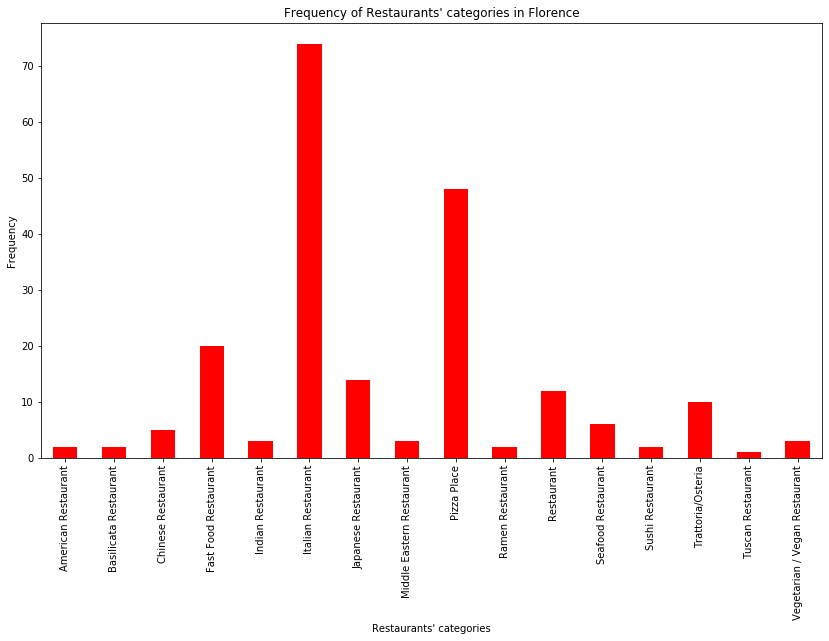

In [50]:
# Now, let's plot the frequencies

category_frequencies.plot(kind='bar', figsize=(14,8), color='red')
plt.title("Frequency of Restaurants' categories in Florence")
plt.xticks(rotation=90)
plt.xlabel("Restaurants' categories")
plt.ylabel('Frequency')

It looks like the generic *Italian Restaurant* category is by far the most represented in the dataframe, while many other categories have very few examples. This evidence needs to be kept in mind when interpreting the results, as any model we build with categories as features will risk to overfit given the few number of examples available for certain categories.

#### Explore the distribution of clusters
Again, we can repeat the analysis by cluster label this time, so to see the number of restaurants contained in each cluster. In the previous section we already saw how many neighborhoods were contained in each cluster but not how many restaurants, that is what we are truly interested in.

Text(0, 0.5, 'Frequency')

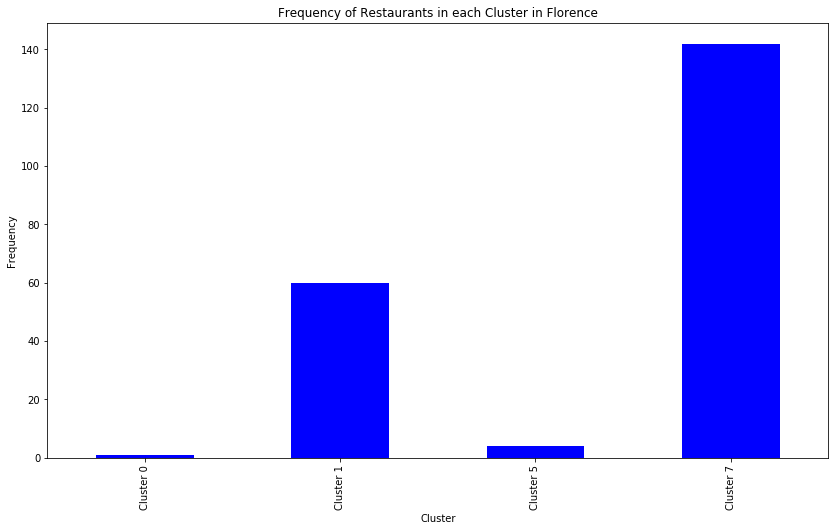

In [53]:
# Let's get the frequency of each cluster by summing up the category dataframe by row

cluster_frequencies = clusters.sum(axis=0).T

# Now, let's plot the frequencies

cluster_frequencies.plot(kind='bar', figsize=(14,8), color='blue')
plt.title("Frequency of Restaurants in each Cluster in Florence")
plt.xticks(rotation=90)
plt.xlabel("Cluster")
plt.ylabel('Frequency')

We can clearly see that the majority of restaurants are contained in cluster 1 and 7. This, again, will mean that using cluster 5 and 0 as features might result in overfitting, given the small number of examples in those clusters. In our case, we will use all the variables anyway, but it is important to keep in mind this evidence for later, when we will acknowledge the limits of our analysis and suggest solutions.

#### Explore both cluster and category at the same time
With the same technique above we can also group the categories of restaurants by cluster and see what the interaction between the two is, by looking at the most prominent categories in each cluster.

In [62]:
# Start by creating a dataframe analogous to the category one

clust_cat = X_all.iloc[:,4:-4]
clust_cat.head()

,American Restaurant,Basilicata Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
# Now let's re-create a list in which the name of the cluster is actually spelled out for the relative row

clust_label = []
for row in X_all.iterrows():
    for index,cluster in enumerate(row[1][-4:]):
        if cluster:
            clust_label.append(X_all.columns.values.tolist()[-4+index]) # access the column name of the cluster having a 1 in the row


In [63]:
# Now we can add the list of cluster name per row to the category-like dataframe previously created

clust_cat['cluster'] = clust_label

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [68]:
# Finally, we aggregate by cluster name and use the sum as the aggregator

clust_cat_grouped = clust_cat.groupby('cluster').sum()

In [85]:
import matplotlib.cm as cm # This library will give us more control over the color being used in the plot

# Set a colormap
color_map = cm.get_cmap('tab20', 20)

Text(0.5, 1.0, 'Frequency of restaurant categories per neighborhood cluster in Florence')

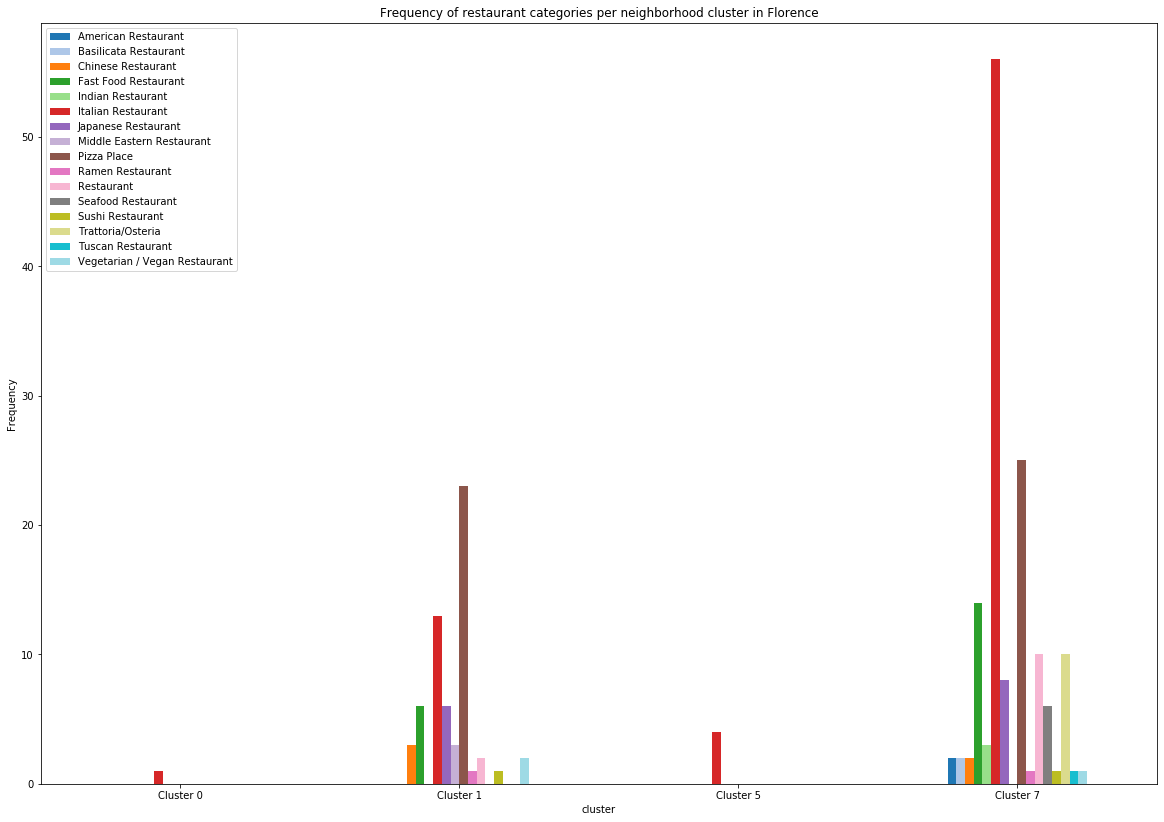

In [87]:
clust_cat_grouped.plot(kind='bar',colormap = color_map, figsize=(20,14))
plt.xticks(rotation=0)
plt.ylabel('Frequency')
plt.title('Frequency of restaurant categories per neighborhood cluster in Florence')

The above image seems to confirm that what previously observed by plotting the clusters' frequency is true also for the restaurants' categories in the minority clusters: cluster 0 and cluster 5, in fact, contains just italian restaurants, while cluster 1 and 7 seems to have the biggest variety of restaurants' categories. This means that the use of cluster 0 and cluster 5 in a model will most likely have just the same effect of the italian restaurant category and, as such, the features should be redundant. For the time being we leave them there, but, if the results of the analysis will prove unsatisfactory, we can try going back and delete the rows pertaining to the two minority clusters.

#### Explore relationship between numerical features and target variable
At this point, we can use the library seaborn and its convenient function *regplot* to see if we can find any linear relationship between our numerical features and the target variable. If such relation is observed for one or more of the features it might mean that we could use a linear model for our purpose (e.g. linear regression).

In [88]:
# import seaborn package
import seaborn as sns

Let's start with distance from centre

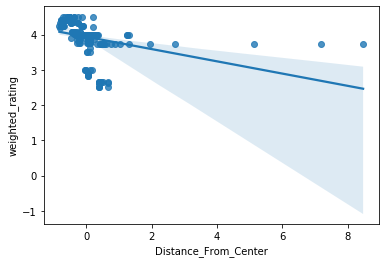

In [90]:
sns.regplot(x=X_all.iloc[:,0],y=y)

In general it looks like the linear relationship assumption between distance from centre and rating would hold with a negative correlation (i.e. the more distant from the centre the less the rating) if it wasn't for some notable outlier represented by very far restaurants. This observation is reasonable, as restaurants close enough to the city centre but a little bit further away than other might be judged more negatively than restaurants that are uniquely local and, therefore, are likely of being rated just by local people. We must also remember that restaurants from certain neighborhoods were rated by very few people in general and, as such, they might have a higher rating due to less reviews received and this effect might not have been tackled by our normalisation methodology (as it assume the average of the neighborhood as the prior on which to backoff in case of few reviews).

Let's go on with number of people living in the borough

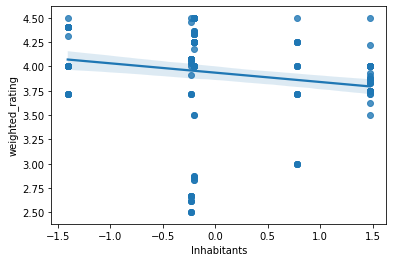

In [91]:
sns.regplot(x=X_all.iloc[:,1],y=y)

In this case a weak negative relationship can be observed between number of inhabitants and rating. The variance is quite big however, as we must remember that number of inhabitants is the same for all restaurants sharing the same borough. The same will apply also to the following numerical features.

Now let's watch what is the relationship between ratings and density of people living in the borough

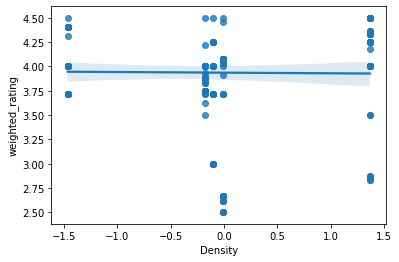

In [92]:
sns.regplot(x=X_all.iloc[:,2],y=y)

In this case no real relationship can be seen as the line is basically flat.

Finally let's see the relationship between borough's area and rating

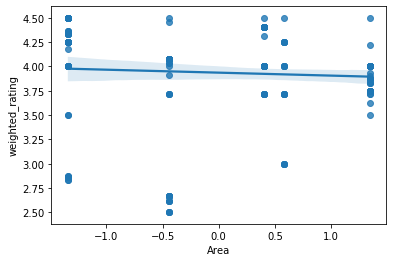

In [93]:
sns.regplot(x=X_all.iloc[:,3],y=y)

Also in this case a clear linear relationship could not be obseved. All this observations suggest that a linear model might not be appropriate to use especially the numerical features or, at least, that such features won't be extremely predective in such a model.

#### Explore Distribution of Ratings
So far, we analysed the distributions of the predictors, but what about the targets? Here we plot an histogram of the target variable so that we can see what we are trying to predict with more precision.

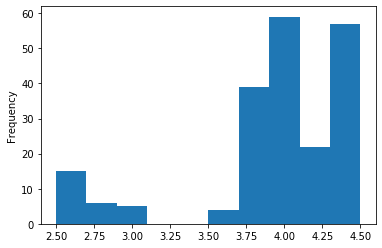

In [94]:
y.plot(kind='hist')

In general, people seem to be generous with restaurants in Florence as the majority of the ratings are concentrated on the right side of the graph. We then might expect our model to tend to predict values in that area as well.

### Multiple Linear Regression
As a first attempt of building a model, we will build a simple multiple linear regression model. Such a model has the advantage of being interpretable via the analysis of the weights of each feature, while the relative speed with which we can build them will allow for us to see how different sets of independent variables behave in the prediction task. We will use the R squared score in conjunction with cross validation to evaluate the results for each set of training features. Cross validation will build and evaluate different models for a predefined number of times with different subsets of the data (in our case 4 subsets) while testing on the left out samples: this way we will also be able to have an idea of the generalisation power of our models. After cross validating, we also re-train with the entire training set for each separate set of features and report the R squared adjusted by the number of predictors as an additional parameter to see what training set works the best when using multiple linear regression to predict restaurants' ratings.
***
#### Build model with X_0
Here we try build the first model with just the demographic and distance from centre information

In [98]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

lr = LinearRegression()
results = cross_val_score(lr, X_0, y, cv=4) # the function accept the model, training set, target variable and number of subsets as input
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  -0.010275633709693227


In [99]:
lr = LinearRegression()
lr.fit(X_0, y)
print('Coefficients: ', lr.coef_) # coefficients obtained after training
print('Intercept: ', lr.coef_) # intercepts of the fitted lines (i.e. their offset on y when x=0)
print('R^2: ', lr.score(X_0,y)) # Measure of variation explained by the model, as opposed to the simple average of target variable as predictor

# The adjusted R^2 will normalise the obtained R^2 score by the number of predictors so as to account for the increase in predictors'
# number when giving a measure of how good the model performed
print('Adjusted R^2:', 1 - (1-lr.score(X_0, y))*(len(y)-1)/(len(y)-X_0.shape[1]-1))

Coefficients:  [-0.09823205 -1.20744504  1.4235718   1.51879033]
Intercept:  [-0.09823205 -1.20744504  1.4235718   1.51879033]
R^2:  0.28477195787502163
Adjusted R^2: 0.27060902634779427


In general this model does not perform as well as we might want it to perform, as its adjusted R^2 amounts to circa 0.27 (max 1.0). Notice how the mean of the cross validation results is even negative, reflecting the fact that our training set is composed of too few examples for the model to learn on subsets of it. Nonetheless, the results from cross-validation can be useful to be compared between features' sets, while giving a measure of how well our model might perform on unseen data (not very well in this case). 

#### Build model with category
Here we try build the first model with just the one-hot encoded categories per restaurant

In [101]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, category.values, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  0.4089287228310452


In [102]:
lr = LinearRegression()
lr.fit(category.values, y)
print('Coefficients: ', lr.coef_) # coefficients obtained after training
print('Intercept: ', lr.coef_) # intercepts of the fitted lines (i.e. their offset on y when x=0)
print('R^2: ', lr.score(category.values,y)) # Measure of variation explained by the model, as opposed to the simple average of target variable as predictor

# The adjusted R^2 will normalise the obtained R^2 score by the number of predictors so as to account for the increase in predictors'
# number when giving a measure of how good the model performed
print('Adjusted R^2:', 1 - (1-lr.score(category.values, y))*(len(y)-1)/(len(y)-category.shape[1]-1))

Coefficients:  [ 0.39213629  0.39213629 -0.22075231 -1.21786195  0.42427915  0.25165522
 -0.03327039  0.02546963 -0.01639648 -1.26619704  0.2293203  -0.0478734
  0.06713629  0.46927915  0.31713629  0.23380296]
Intercept:  [ 0.39213629  0.39213629 -0.22075231 -1.21786195  0.42427915  0.25165522
 -0.03327039  0.02546963 -0.01639648 -1.26619704  0.2293203  -0.0478734
  0.06713629  0.46927915  0.31713629  0.23380296]
R^2:  0.7486742466913886
Adjusted R^2: 0.7275099727285581


The category of the restaurant seems to perform much better as we can explain around 72% of the variation in our ratings by just looking at the category of the relative restaurant. Also the results obtained by cross validation seem more promising this time.

#### Build model with clusters
Here we try build the first model with just the one-hot encoded clusters per restaurant's neighborhood

In [104]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, clusters.values, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  -0.5301578983372577


In [105]:
lr = LinearRegression()
lr.fit(clusters.values, y)
print('Coefficients: ', lr.coef_) # coefficients obtained after training
print('Intercept: ', lr.coef_) # intercepts of the fitted lines (i.e. their offset on y when x=0)
print('R^2: ', lr.score(clusters.values,y)) # Measure of variation explained by the model, as opposed to the simple average of target variable as predictor

# The adjusted R^2 will normalise the obtained R^2 score by the number of predictors so as to account for the increase in predictors'
# number when giving a measure of how good the model performed
print('Adjusted R^2:', 1 - (1-lr.score(clusters.values, y))*(len(y)-1)/(len(y)-clusters.shape[1]-1))

Coefficients:  [-0.08171646 -0.06097574 -0.08171646  0.22440866]
Intercept:  [-0.08171646 -0.06097574 -0.08171646  0.22440866]
R^2:  0.06533280577743106
Adjusted R^2: 0.04682454450569706


Using just the clusters' labels the restaurants belong to as predictors result in very poor performance. This is understandable if we think about the clusters' labels distribution above and we remember that the majority of the restaurants are concentrated in two clusters. What can be inferred is that the variation of ratings also inside those two clusters must be quite high.

#### Build model with X_category
Now let's try to build a model with the restaurants' categories and the demographic and distance from centre features.

In [108]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, X_category, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  0.5566935149392144


In [109]:
lr = LinearRegression()
lr.fit(X_category, y)
print('Coefficients: ', lr.coef_) # coefficients obtained after training
print('Intercept: ', lr.coef_) # intercepts of the fitted lines (i.e. their offset on y when x=0)
print('R^2: ', lr.score(X_category,y)) # Measure of variation explained by the model, as opposed to the simple average of target variable as predictor

# The adjusted R^2 will normalise the obtained R^2 score by the number of predictors so as to account for the increase in predictors'
# number when giving a measure of how good the model performed
print('Adjusted R^2:', 1 - (1-lr.score(X_category, y))*(len(y)-1)/(len(y)-X_category.shape[1]-1))

Coefficients:  [-0.07748461 -0.37086403  0.42101449  0.39044705  0.24286006  0.24084284
 -0.14369054 -1.16353323  0.34732861  0.2216312   0.00148979  0.0876747
  0.03169366 -1.13498064  0.21825391 -0.0212822   0.04964215  0.35081749
  0.41925251  0.2519997 ]
Intercept:  [-0.07748461 -0.37086403  0.42101449  0.39044705  0.24286006  0.24084284
 -0.14369054 -1.16353323  0.34732861  0.2216312   0.00148979  0.0876747
  0.03169366 -1.13498064  0.21825391 -0.0212822   0.04964215  0.35081749
  0.41925251  0.2519997 ]
R^2:  0.817756257516003
Adjusted R^2: 0.7981601561736378


Combining demographic, distance from centre and restaurant category information seem to work pretty well, as just 20% of variance in ratings remain unexplained and also the out of sample testing via cross validation leads to a decent performance.

#### Build model with X_cluster
Now let's try to build a model with the restaurants' neighborhoods' clusters and the demographic and distance from centre features.

In [112]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, X_clusters, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  -0.3554774125181178


In [113]:
lr = LinearRegression()
lr.fit(X_clusters,y)
print('Coefficients: ', lr.coef_)
print('Intercept: ', lr.coef_)
print('R^2: ', lr.score(X_clusters,y))
print('Adjusted R^2:', 1 - (1-lr.score(X_clusters, y))*(len(y)-1)/(len(y)-X_clusters.shape[1]-1))

Coefficients:  [-0.16140255 -1.13603984  1.37634213  1.50679723  1.1730092  -0.52383224
 -0.27910401 -0.37007295]
Intercept:  [-0.16140255 -1.13603984  1.37634213  1.50679723  1.1730092  -0.52383224
 -0.27910401 -0.37007295]
R^2:  0.3271410379338979
Adjusted R^2: 0.29995481724435846


The combination of clusters and information in X_0 seem to work slightly better than X_0 alone, judging by the adjusted R^2. When we look at the cross validation results, however, we can see how this combination generalises quite bad. Again, this could be an effect of the two minority clusters creating a problem with overfitting.

#### Build model with cluster_category
Now let's try to build a model with the restaurants' neighborhoods' clusters and the restaurants' category information.

In [115]:
# Define the features from the X_all variable.

cluster_category = X_all.iloc[:, 4:]

In [116]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, cluster_category, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  0.485685630029856


In [117]:
lr = LinearRegression()
lr.fit(cluster_category,y)
print('Coefficients: ', lr.coef_)
print('Intercept: ', lr.coef_)
print('R^2: ', lr.score(cluster_category,y))
print('Adjusted R^2:', 1 - (1-lr.score(cluster_category, y))*(len(y)-1)/(len(y)-cluster_category.shape[1]-1))

Coefficients:  [ 0.33340923  0.33340923 -0.16692611 -1.22031239  0.36555209  0.26194826
 -0.01160227  0.15433134  0.01476275 -1.23112972  0.20185804 -0.10660046
  0.10220362  0.41055209  0.25840923  0.30013508 -0.2199862   0.12619181
 -0.2199862   0.31378058]
Intercept:  [ 0.33340923  0.33340923 -0.16692611 -1.22031239  0.36555209  0.26194826
 -0.01160227  0.15433134  0.01476275 -1.23112972  0.20185804 -0.10660046
  0.10220362  0.41055209  0.25840923  0.30013508 -0.2199862   0.12619181
 -0.2199862   0.31378058]
R^2:  0.7909757305807785
Adjusted R^2: 0.7685000026862385


Also this combination seems to work pretty well and slightly better than category alone, confirming the utility of such features and proving that adding cluster information in this case might improve the model overall.

#### Build model with all the features
Finally, let's see if adding all the features together will further improve the model.

In [118]:
# Same process as above

lr = LinearRegression()
results = cross_val_score(lr, X_all, y, cv=4)
print('Average R^2 for the 4 subsets: ', results.mean())

Average R^2 for the 4 subsets:  0.4352325190927132


In [119]:
lr = LinearRegression()
lr.fit(X_all,y)
print('Coefficients: ', lr.coef_)
print('Intercept: ', lr.coef_)
print('R^2: ', lr.score(X_all,y))
print('Adjusted R^2:', 1 - (1-lr.score(X_all, y))*(len(y)-1)/(len(y)-X_all.shape[1]-1))

Coefficients:  [-0.07401006 -0.37981541  0.43606995  0.4185035   0.23756573  0.23563897
 -0.14720456 -1.15563468  0.34773118  0.22728606 -0.00215032  0.10130411
  0.03202593 -1.11833865  0.2158646  -0.0291699   0.05409546  0.34610288
  0.39721341  0.25766978  0.28945467 -0.03429524 -0.26507315  0.00991373]
Intercept:  [-0.07401006 -0.37981541  0.43606995  0.4185035   0.23756573  0.23563897
 -0.14720456 -1.15563468  0.34773118  0.22728606 -0.00215032  0.10130411
  0.03202593 -1.11833865  0.2158646  -0.0291699   0.05409546  0.34610288
  0.39721341  0.25766978  0.28945467 -0.03429524 -0.26507315  0.00991373]
R^2:  0.8246944098142289
Adjusted R^2: 0.801577189130391


We see that including all the features give us the best adjusted R^2, but, at the same time, it gives a slightly lower average of R^2 obtained via cross validation. In the exploratory data analysis part we saw how especially the demographic information do not seem to be linearly correlated with the ratings of the restaurant and we highlighted how this could be very well an effect of the fact that such information are not even at the neighborhood level, so that fail to give a fine-grained enough picture of the restaurants' location. At this point, we can either choose the X_category based model as the best one or the X_all based, according to whether we want a model that generalises better or that performs better on our training set. For now, we decide to keep the X_all model as our best one, considering that Florence is a relatively small city and the population of restaurants in Florence won't be so much larger than the sample we collected.

### Regression Tree
We saw that a multiple linear regression model could perform quite wel and give us interpretable weights to assess the importance of different factors in a restaurant success in Florence. Can we do better? If we think back at the non-linear nature of the relationship between certain features and the ratings, then we might consider also a non-linear model that is easily interpretable as well. Such a model exists in the form of regression trees, a generalisation of decision tree to predict continuous values. Such models can be easily built via sklearn and also have the advantage of given interpretable rules leading to the obtained results: seems exactly what we might want!

#### Exploring different training sets via cross-validation and adjusted R^2
In this section we repeat what we did with multiple linear regression by building multiple regression trees with different subsets of the total features and report the obtained results so as to choose the best set of features for the task at hand. In this case we do all of this in one go, as the process was made clear above. 

In [122]:
from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)

print("Average R^2 for regression tree with X_0: ", cross_val_score(regressor, X_0, y, cv=4).mean())
regressor_0 = DecisionTreeRegressor(random_state=0)
regressor_0.fit(X_0, y)
print('Adjusted R^2 for Regression Tree with X_0: ', 1 - (1-regressor_0.score(X_0, y))*(len(y)-1)/
      (len(y)-X_0.shape[1]-1))
print('')
print("Average R^2 for regression tree with X_category: ", cross_val_score(regressor, X_category, y, cv=4).mean())
regressor_cat = DecisionTreeRegressor(random_state=0)
regressor_cat.fit(X_category, y)
print('Adjusted R^2 for Regression Tree with X_category: ', 1 - (1-regressor_cat.score(X_category, y))*(len(y)-1)/
      (len(y)-X_category.shape[1]-1))
print('')
print("Average R^2 for regression tree with X_clusters: ", cross_val_score(regressor, X_clusters, y, cv=4).mean())
regressor_clus = DecisionTreeRegressor(random_state=0)
regressor_clus.fit(X_clusters, y)
print('Adjusted R^2 for Regression Tree with X_clusters: ', 1 - (1-regressor_clus.score(X_clusters, y))*(len(y)-1)/
      (len(y)-X_clusters.shape[1]-1))
print('')
print("Average R^2 for regression tree with cluster_category: ", cross_val_score(regressor, cluster_category, y, cv=4).mean())
regressor_clus_cat = DecisionTreeRegressor(random_state=0)
regressor_clus_cat.fit(cluster_category, y)
print('Adjusted R^2 for Regression Tree with cluster_category: ', 1 - (1-regressor_clus_cat.score(cluster_category, y))*(len(y)-1)/
      (len(y)-cluster_category.shape[1]-1))
print('')
print("Average R^2 for regression tree with clusters: ", cross_val_score(regressor, clusters.values, y, cv=4).mean())
regressor_just_clus = DecisionTreeRegressor(random_state=0)
regressor_just_clus.fit(clusters, y)
print('Adjusted R^2 for Regression Tree with clusters: ', 1 - (1-regressor_just_clus.score(clusters, y))*(len(y)-1)/
      (len(y)-clusters.shape[1]-1))
print('')
print("Average R^2 for regression tree with category: ", cross_val_score(regressor, category.values, y, cv=4).mean())
regressor_just_cat = DecisionTreeRegressor(random_state=0)
regressor_just_cat.fit(category, y)
print('Adjusted R^2 for Regression Tree with category: ', 1 - (1-regressor_just_cat.score(category, y))*(len(y)-1)/
      (len(y)-category.shape[1]-1))
print('')
print("Average R^2 for regression tree with X_all: ", cross_val_score(regressor, X_all, y, cv=4).mean())
regressor_all = DecisionTreeRegressor(random_state=0)
regressor_all.fit(X_all, y)
print('Adjusted R^2 for Regression Tree with X_all: ', 1 - (1-regressor_all.score(X_all, y))*(len(y)-1)/
      (len(y)-X_all.shape[1]-1))

Average R^2 for regression tree with X_0:  -0.4703451194909781
Adjusted R^2 for Regression Tree with X_0:  0.9960210748738119

Average R^2 for regression tree with X_category:  0.2829558152990807
Adjusted R^2 for Regression Tree with X_category:  0.9956788016624625

Average R^2 for regression tree with X_clusters:  0.051654425558248174
Adjusted R^2 for Regression Tree with X_clusters:  0.9959406925480303

Average R^2 for regression tree with cluster_category:  0.5344136694096104
Adjusted R^2 for Regression Tree with cluster_category:  0.7856320280681252

Average R^2 for regression tree with clusters:  -0.5298042764394835
Adjusted R^2 for Regression Tree with clusters:  0.04682454450569706

Average R^2 for regression tree with category:  0.40156274254503815
Adjusted R^2 for Regression Tree with category:  0.7275099727285581

Average R^2 for regression tree with X_all:  0.6570017976848547
Adjusted R^2 for Regression Tree with X_all:  0.9955838302704286


Also in this case, the regression tree seems to be able to balance out of sample performance and adjusted R^2 when using all the features, therefore proving one more that such a configuration is the most effective. We can, in fact, see that certain results when using this model might be overly relying on specific observations, as suggested by the model built with X_0 that performs almost perfectly when using the entire training set, but fails totally to convince when using cross validation. Regression trees have indeed a known tendency to overfit, but the last configuration gives us the best result also in terms of average out of sample R^2. We can then take the saved regressor_all model as our best model.

## Results and Discussion <a name='results'>
By performing all of the above analysis, we were able to create two different models giving good results in the rating prediction task. Starting by those two models we can then interpret their rationale and, consequently, understand the factors of a restaurant success. We do this by performing the following operations:
- create a dataframe of the weights associated with the predictors in the multiple regression model and visualise them: the bigger the weight, the stronger the effect of the variable on the rating (positive or negative according to the sign of the weight).
- create a visualisation showing the decision making process of the regression tree.

### Factors of Restaurant Success according to the Multiple Regression Model
We will create a dataframe of coefficients' magnitude and associated predictors' names. We can then visualise it with a barplot.

Text(0.5, 1.0, "Explicatory Variables' Magnitude")

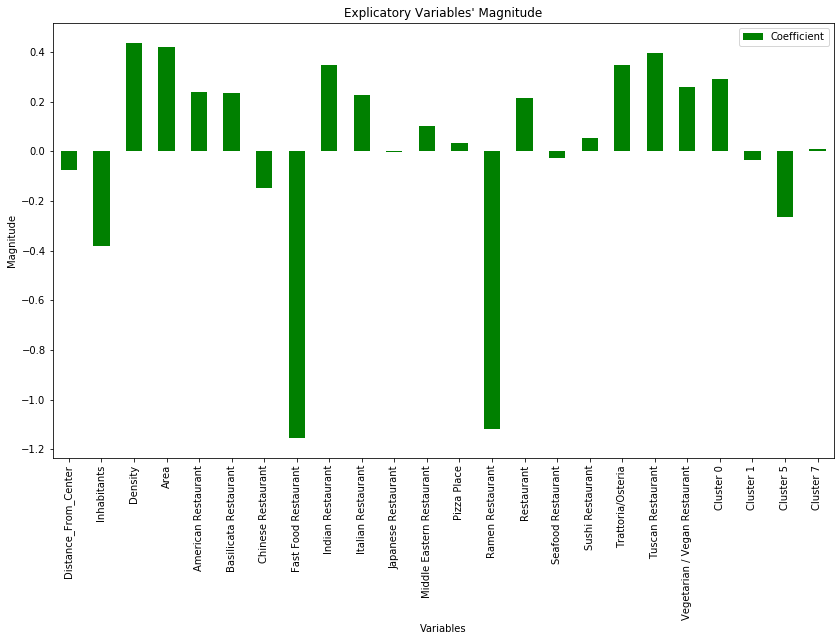

In [134]:
# Extract the relevant coefficients and associated variables' name from the multiple regression model

coefs = pd.DataFrame({'Variable':X_all.columns.values.tolist(), 'Coefficient':lr.coef_})
coefs.plot(kind='bar', x='Variable', figsize=(14,8), color='green')
plt.xlabel('Variables')
plt.ylabel('Magnitude')
plt.title("Explicatory Variables' Magnitude")

From this picture we can see the important factors for a success of a restaurant in Florence, according to the Multiple Linear Regression Model. Important highlights include:

- Fast-food restaurants do not seem to be particularly appreaciated in Florence, nor Ramen Restaurants.
- Staying in a densely populated and large enough area might help your restaurant having success, probably because many people are available as potential customer but the competition is more distributed.
- Indian, Italian, Tuscanian Restaurants and Trattorie (typical restaurants) seem to be appreciated type of restaurants.

These results must be interpreted under the light of the performance of the multiple linear regression model, as shown in the previous section, but, in general, can give a direction to people who wants to invest in restoration in Florence.

### Factors of Restaurant Success According to the Regression Tree
At this point we can visualise the decision process of the regression tree, so as to see if similar conclusions were drawn also by this model.

In [7]:
from sklearn import tree # this library from sklearn make the visualisation of a decision/regression tree extremely easy

In [11]:
# Here we visualise the tree we built with all the features. We make sure of making the picture very big as the tree will be
# extremely large

fig = plt.figure(figsize=(200,200))
_ = tree.plot_tree(regressor_all, 
                   feature_names=X_all.columns.values.tolist(),  
                   filled=True)

The tree is very big and, as such, reading in the various boxes is very hard. By downloading the above image and zoom into it, however, the various factor leading to a prediction can be individuated. In particular, it can be seen how the decisions over dummy variables are represented as *category*<=0.5, meaning *if is not that category*. The results of the regression tree seems to confirm the ones from the multiple regression model in the importance it's given to the various features. In particular, the first split highlight once more and even more strongly that to have success in ratings in Florence you should not open a fast-food restaurant and the same applies to Ramen restaurants.

### Predicting with the models
Now, let's assume that we already have a location and a type of restaurant in mind: what rating on TripAdvisor we might expect? Let's look at this by predicting with the two models

In [141]:
X_all.head()

,Distance_From_Center,Inhabitants,Density,Area,American Restaurant,Basilicata Restaurant,Chinese Restaurant,Fast Food Restaurant,Indian Restaurant,Italian Restaurant,Japanese Restaurant,Middle Eastern Restaurant,Pizza Place,Ramen Restaurant,Restaurant,Seafood Restaurant,Sushi Restaurant,Trattoria/Osteria,Tuscan Restaurant,Vegetarian / Vegan Restaurant,Cluster 0,Cluster 1,Cluster 5,Cluster 7
0,-0.816490,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,-0.780051,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-0.766702,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.788942,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,-0.770886,-0.201924,1.367729,-1.343595,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [145]:
# Encode an indian restaurant with the one-hot encoding
indian_restaurant = np.zeros((1,len(list(category.keys()))))
indian_restaurant[0][category.columns.values.tolist().index('Indian Restaurant')] = 1.0

# Let's do the same with cluster, assuming that we want to be in cluster 7
cluster_restaurant = np.zeros((1,4))
cluster_restaurant[0][3] = 1.0

# Also let's sample a realistic distance from centre, inhabitans, density and area
features_restaurant =  np.array([[-0.7, -0.201924, 1.367729, -1.343595]])

example_restaurant = np.concatenate((features_restaurant, indian_restaurant, cluster_restaurant), axis=1)
print("Prediction for the example restaurant with multiple linear regression model: ", lr.predict(example_restaurant)[0])
print('')
print("Prediction for the example restaurant with regression tree model: ", 
      regressor_all.predict(example_restaurant)[0])

Prediction for the example restaurant with multiple linear regression model:  4.454758295479506

Prediction for the example restaurant with regression tree model:  4.250034838350056


## Conclusion <a name='conclusion'>
In this report I have used geolocation data, demographic information and restaurants' categories to build predictive models to predict rating of Florentine restaurant as appearing on TripAdvisor. This way I could open up the models themselves and see what features might determine a restaurant success in Florence, while having a mean of predicting the eventual success (always in terms of rating on TripAdvisor) of restaurant to be opened in the city.<br><br>In general, the overall project might benefit from additional data, as it could be seen that certain neighborhoods were under-represented, while demographic data was not fine-grained enough to make it very relevant in predicting a restaurant's rating. The pipeline, however, gave reasonable results and, as such, it could be applied to other cities or replicated for the same city as more data become available, therefore giving increasing value over time to stakeholders.